<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Histograms and PDFs</h1>
### Notebook contributed by Leo Siqueira

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Ways of estimating a PDF from some numbers
1. <a href="#histograms">Histograms</a>
1. <a href="#kernels">Kernels</a>

In [7]:
import matplotlib as mpl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Math, Latex
from numpy.random import rand
from pylab import rcParams, pcolor, show,colorbar, xticks, yticks, title, figure
from IPython.display import Image

# Consider some (pairs of) numbers: a scatterplot

In [10]:
# Define a figure: scatterplot. 

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
rcParams['figure.figsize'] = (11, 6.5)

def fig5():
    fig,ax=plt.subplots(1,1)
    ax.plot(x,y,'.')
    ax.set_xlabel('x [units]');ax.set_ylabel('y [units]')
    

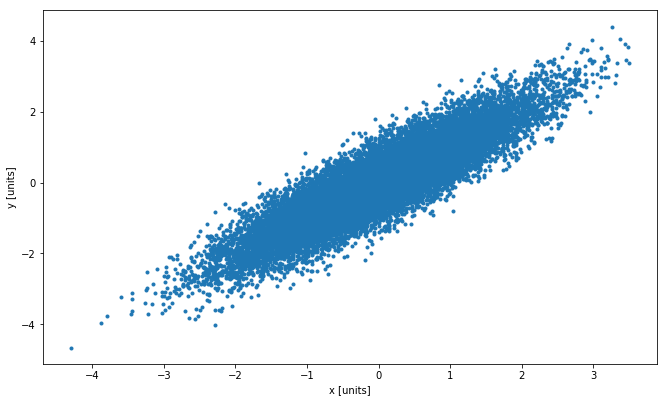

In [11]:
# Make up spme data:

N=20000
ntosig=0.5
x = np.random.randn(N)
y = x + np.random.randn(N)*ntosig

# PLOT IT
fig5()

Quite messy, with many data points to plot.

<a name="histograms"></a>
### Beyond the scatterplot: histogram methods
The dots cover each other, so a better way to look at this is to _contour or image the data density in bins_,
counting how many points fall in each bin. Let's do it first in the general plotting package Matplotlib, then in a more specifically statistal graphics package called Seaborn.


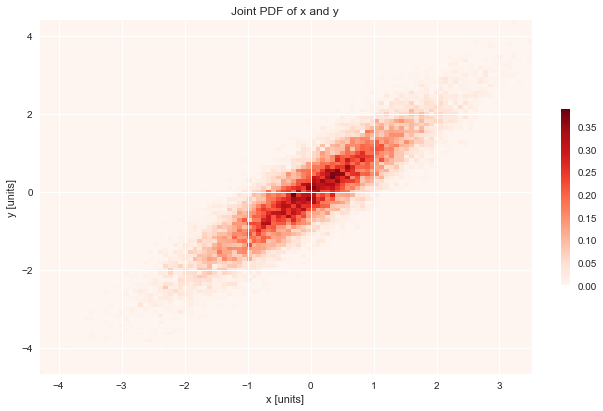

In [20]:
import matplotlib.cm as cm  # import the colormaps.
fig,ax=plt.subplots(1,1)    # Create a result-shaped container (a fig)

# Make the 2D histogram with 100 bins
(n,xx,yy,im)=ax.hist2d(x,y,bins=100,cmap=cm.Reds,cmin=0.,normed=True)

# Plot it, with a colorbar
plt.colorbar(im,shrink=0.5)
ax.set_xlabel('x [units]'); ax.set_ylabel('y [units]')
ax.set_title('Joint PDF of x and y')
plt.show()

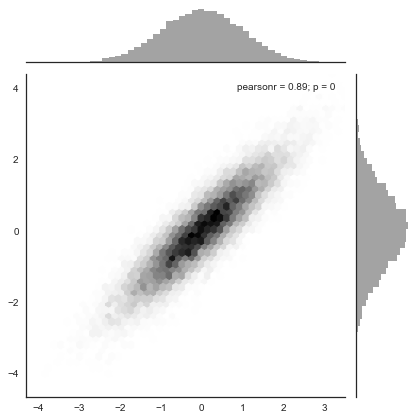

In [21]:
# Do it in Seaborn, with the marginal distributions on the top and side
import seaborn as sns
sns.set(color_codes=True)

df = pd.DataFrame({'x': x, 'y': y})
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");

#### Big question: *How many bins?* 

There are many ways, but one rule of thumb is the **Freedman-Diaconis rule**. For this, you compute the Inter-Quartile-Range (IQR). 
If there are 1500 data points, you lay them out in ascending order... and take the 375th term (the one 25% of the way along)
and the 1125th term (the one 75% of the way along). This is the IQR. You also know N, the number of samples, which in this case in 1500. Now double it.

$BinSize = 2\frac{value(1125)-value(375)}{^{3}\sqrt{1500}}$

### When data are sparse, histograms are crude. 

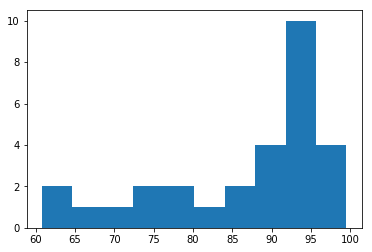

In [8]:
grades = np.array((93.5,93,60.8,94.5,82,87.5,91.5,99.5,86,
                   93.5,92.5,78,76,69,94.5,89.5,92.8,78,65.5,
                   98,98.5,92.3,95.5,76,91,95,61.4,96,90))
junk = plt.hist(grades)

### Why is a histogram not sufficient?

We can play around with the number of bins, but it's not totally clear what's going on with the left half of the grades.

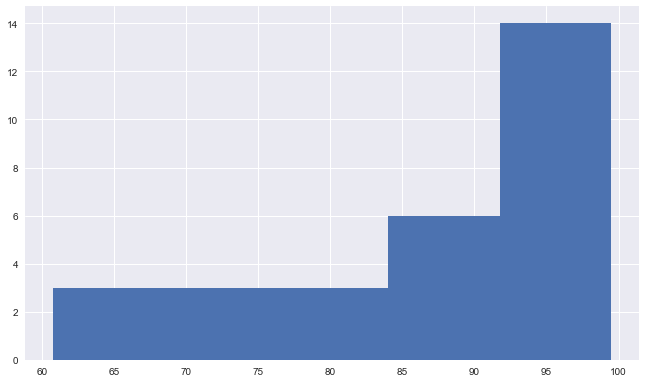

In [31]:
junk = plt.hist(grades,5)

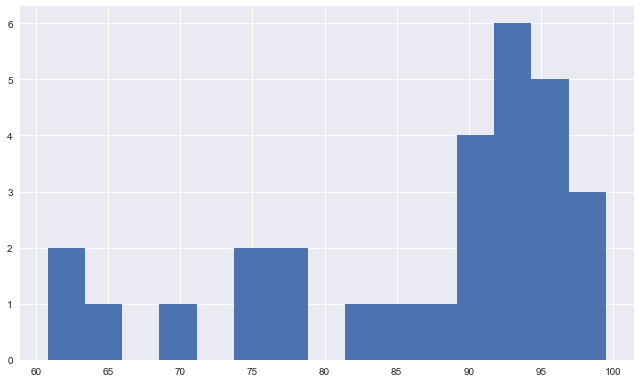

In [32]:
junk = plt.hist(grades,15)

optimal # of bins:  12.0


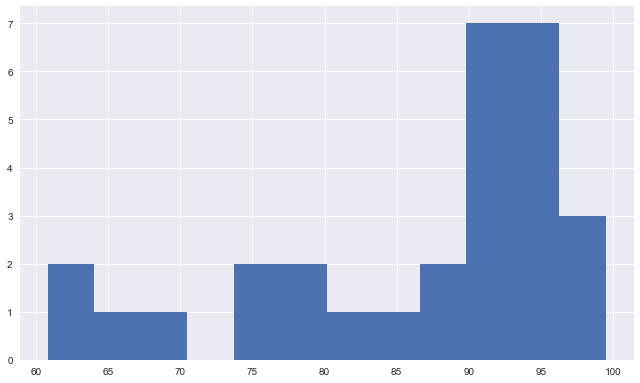

In [33]:
# Let's try that rule of thumb

q75, q25 = np.percentile(grades, [75 ,25])
iqr = q75 - q25
fdr = (2.*np.ceil(iqr))/(np.power(len(grades),1./3))
print ('optimal # of bins: ', np.ceil(fdr))
fdr_hist = plt.hist(grades,np.ceil(fdr).astype(int))

So, maybe the histogram isn't the perfect tool for the job at hand. 

### Two of the main problems with histograms are 

1. you need to define a bin size (many ways) and 
2. you need to decide where the left edge of the bin is. 

Let's look at the effects of bin size on histograms. 

#### Let's create a function called `getHistBinNumAni`.
What does that do? Given a data set, it'll give us an interactive plot. By dragging the slider, we can make a histogram with anywhere from 1 bin to some max (default: 20) number of bins.
No matter how many bins we have, the actual data is shown in blue dots near the bottom. 
Here's what it looks like for the grades:

In [9]:
from numpy import histogram as nphistogram
from JSAnimation.IPython_display import display_animation, anim_to_html
from matplotlib import animation as animation


def getHistBinNumAni(data,totalframes=None,showpts=True):
    #ion()
    if totalframes is None:
        totalframes = min(len(data)-1,100)
    fig = figure()
    ax = fig.gca()

    n, bins, patches = plt.hist(data, totalframes, normed=1, facecolor='green', alpha=0.0)
    if showpts:
        junk = plt.plot(data,0.2*np.ones_like(data),'bo')
    def animate(i):
        n, bins = nphistogram(data, i+1, normed=False)
        #print n
        ax.set_ylim(0,1.1*n.max())
        for j in range(len(n)):
            rect,h = patches[j],n[j]
            #print h.max()
            x = bins[j]
            w = bins[j+1] - x
            rect.set_height(h)
            rect.set_x(x)
            rect.set_width(w)
            rect.set_alpha(0.75)
        #fig.canvas.draw()
    
    ani = animation.FuncAnimation(fig, animate, totalframes, repeat=False)
    return ani


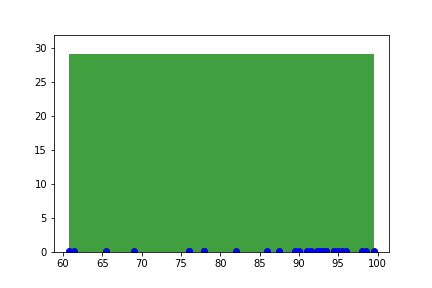
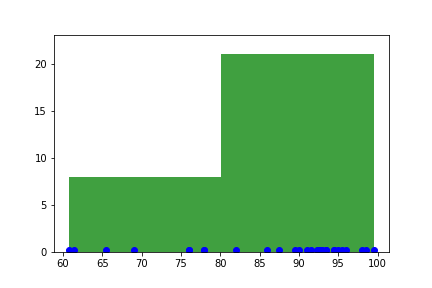
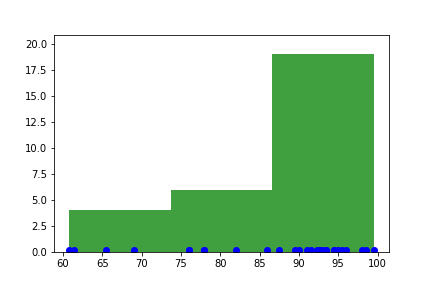
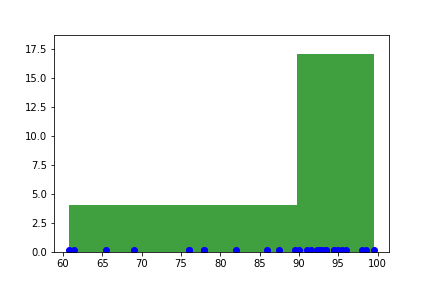
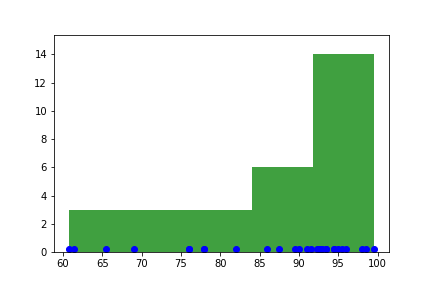
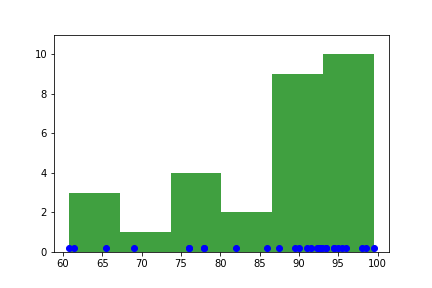
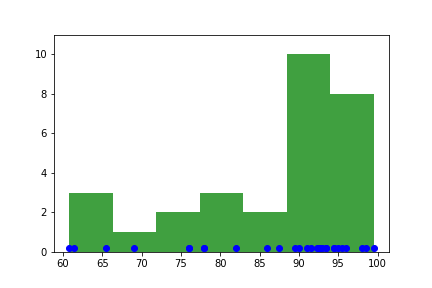
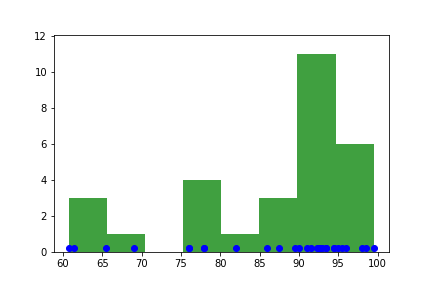
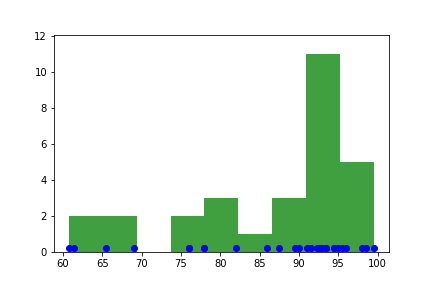
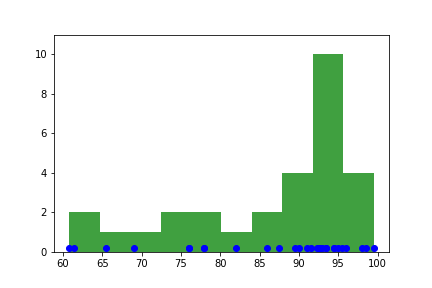
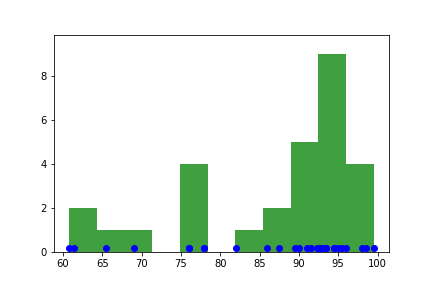
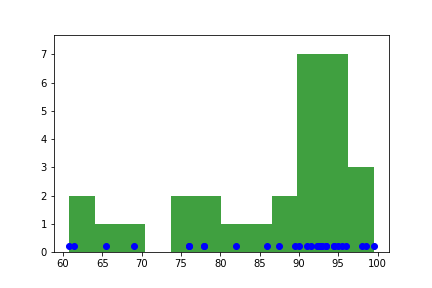
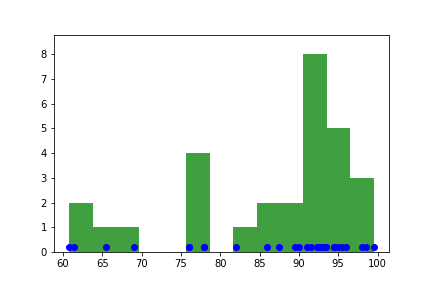
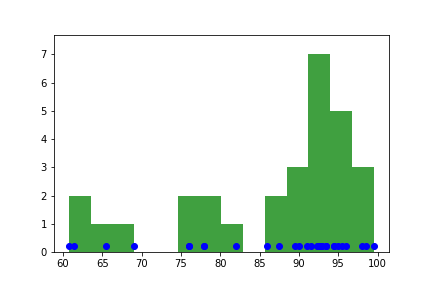
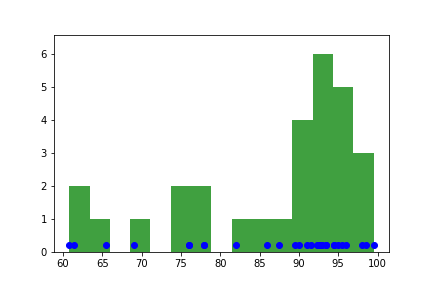
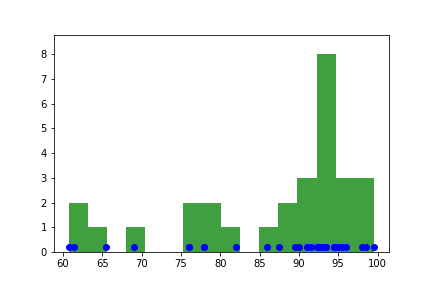
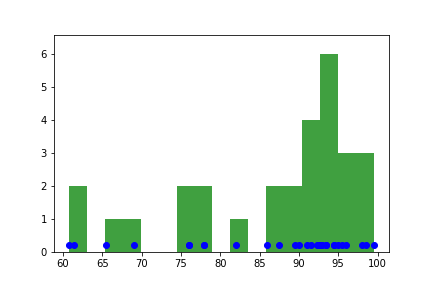
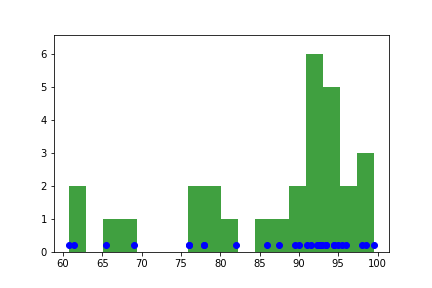
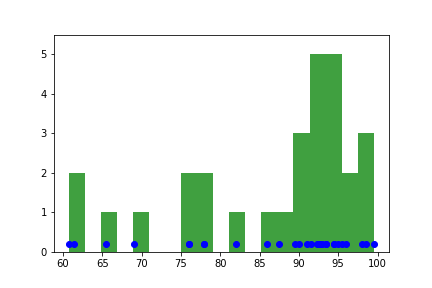
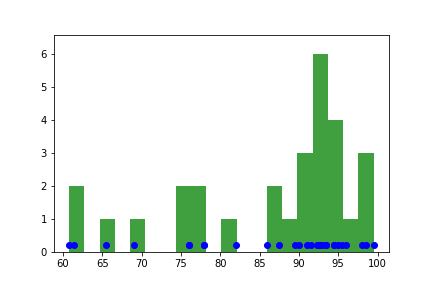
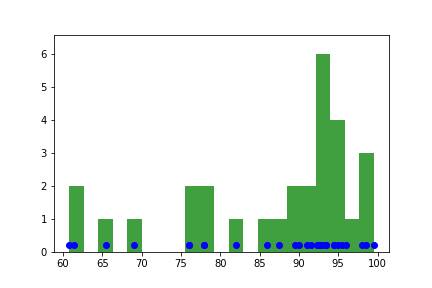
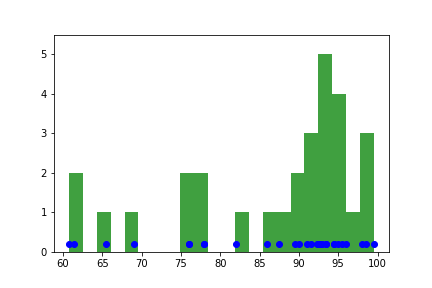
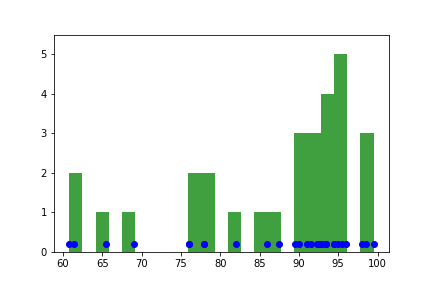
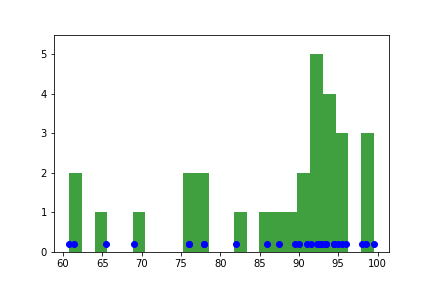
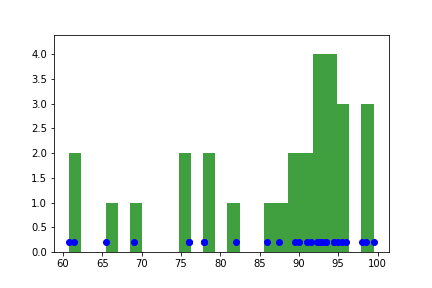
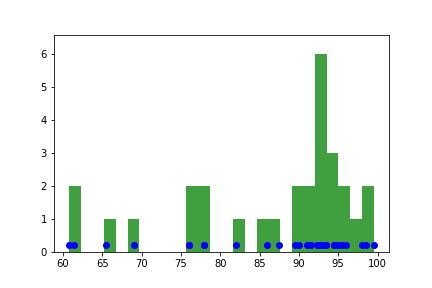
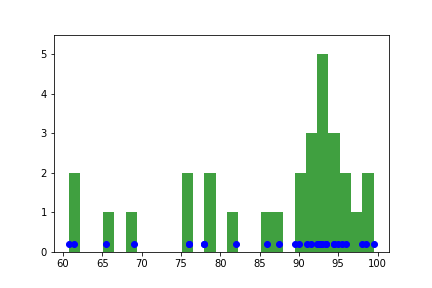
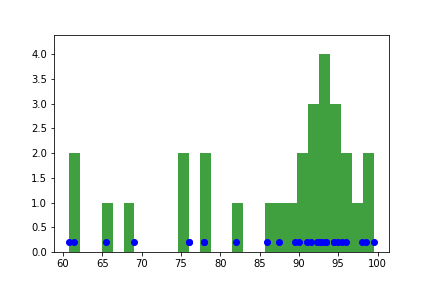

In [10]:
ani = getHistBinNumAni(grades)
display_animation(ani, default_mode='once')

### So, the number of bins makes a huge difference.

### Now the other ambiguity: where do the histogram bins start?

Let's create another function, `getHistBinOffsetAni`, that slides the arbitrary position

In [11]:
%pylab inline
def getHistBinOffsetAni(data,nbins=20,showpts=True): 
    offsets = np.linspace(-0.5,0.5,50)
    totalframes = len(offsets)
    fig = figure()
    ax = fig.gca()

    n, _bins, patches = plt.hist(data, nbins, normed=1, facecolor='green', alpha=0.0)
    if showpts:
        junk = plt.plot(data,0.2*np.ones_like(data),'bo')
    # Obnoxious: find max number in a bin ever
    nmax = 1
    for i in range(totalframes):
        dx = (data.max() - data.min())/nbins
        _bins = np.linspace(data.min() - dx + offsets[i]*dx, data.max()+dx + offsets[i]*dx,len(data)+1)
        n, bins = nphistogram(data, bins=_bins, normed=False)
        nmax = max(nmax,n.max())
                               
    def animate(i):
        dx = (data.max() - data.min())/nbins
        # bins go from min - dx to max + dx, then offset.
        _bins = np.linspace(data.min() - dx + offsets[i]*dx, data.max()+dx + offsets[i]*dx,nbins)
        n, bins = nphistogram(data, bins = _bins, normed=False)
        ax.set_ylim(0,1.1*nmax)
        #ax.set_xlim(data.min()-dx,data.max()+dx)
        binwidth = bins[1] - bins[0]
        ax.set_xlim(bins[0]-binwidth,bins[-1] + binwidth)

        for j in range(len(n)):
            #continue
            rect,h = patches[j],n[j]
            #print h.max()
            x = bins[j]
            w = bins[j+1] - x
            rect.set_height(h)
            rect.set_x(x)
            rect.set_width(w)
            rect.set_alpha(0.75)
        fig.canvas.draw()    
    ani = animation.FuncAnimation(fig, animate, totalframes, repeat=False)
    return ani

Populating the interactive namespace from numpy and matplotlib



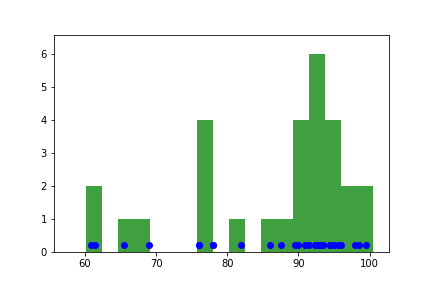
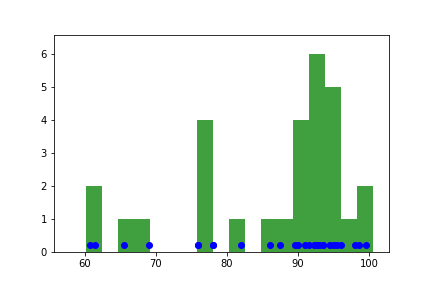
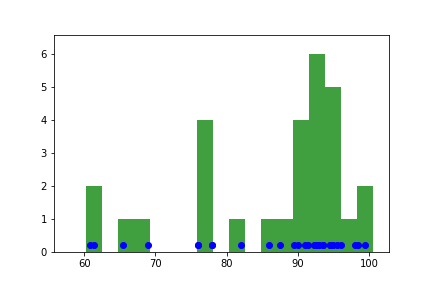
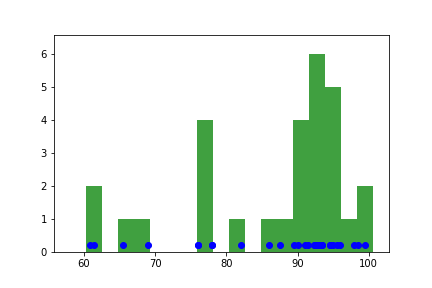
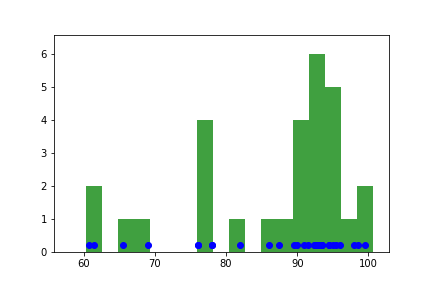
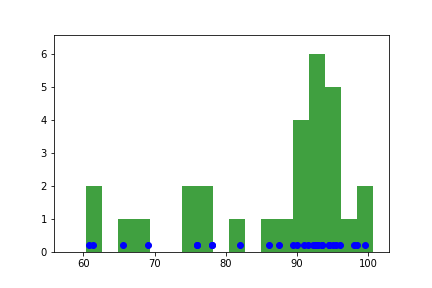
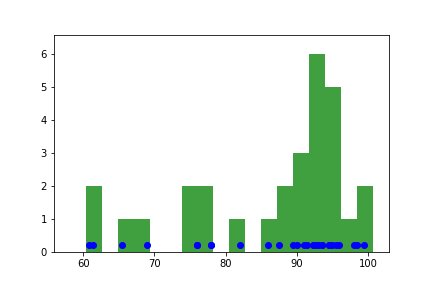
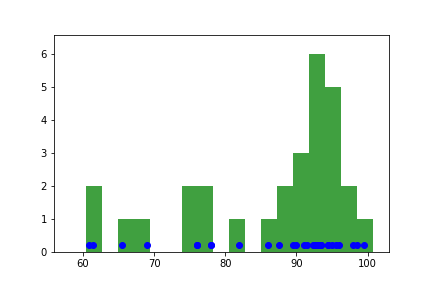
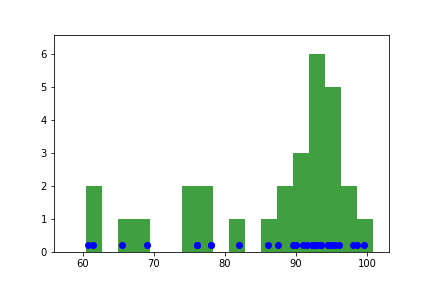
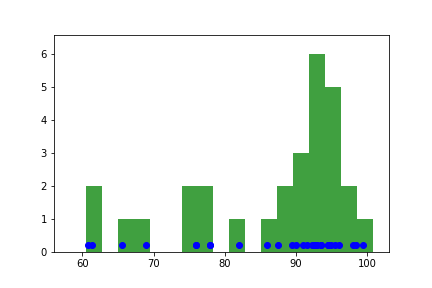
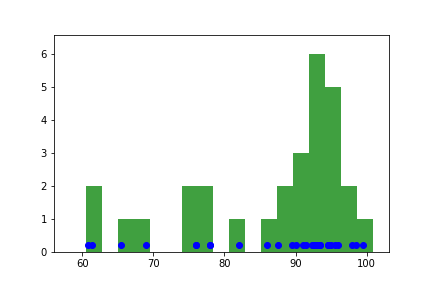
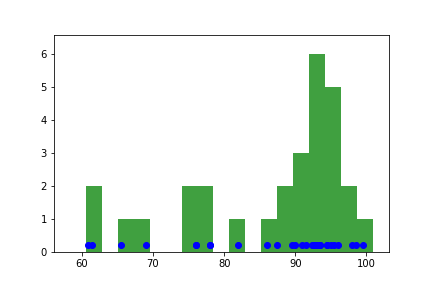
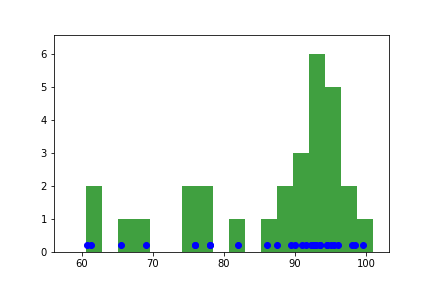
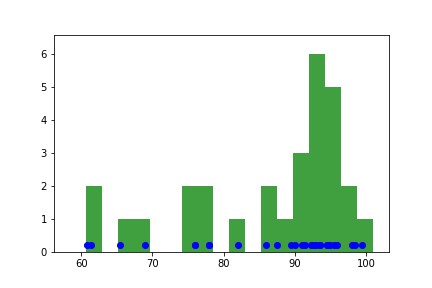
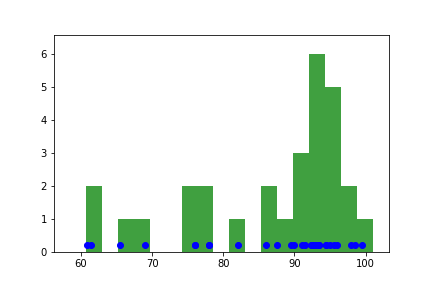
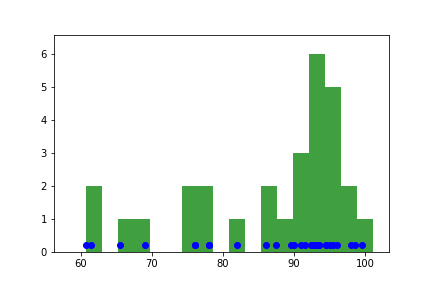
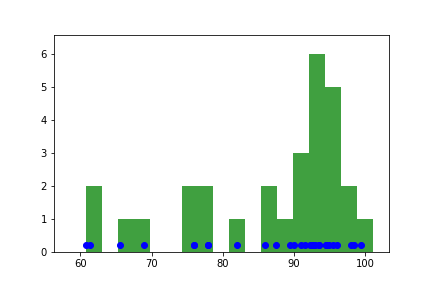
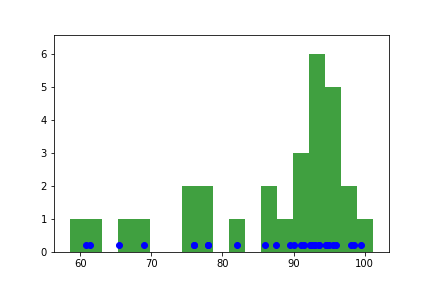
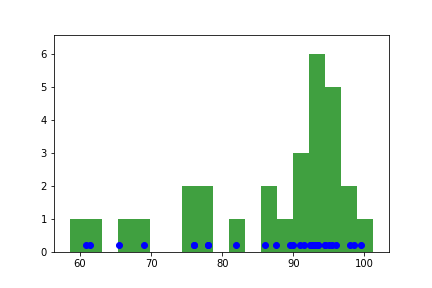
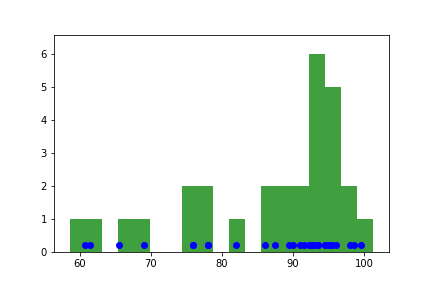
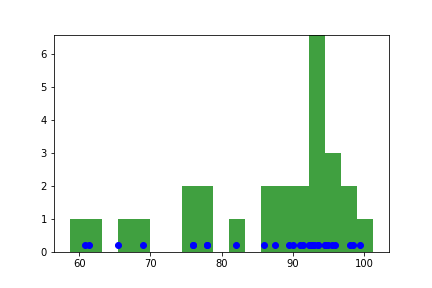
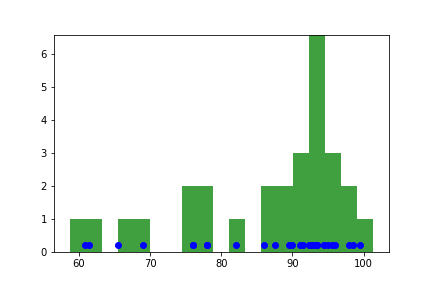
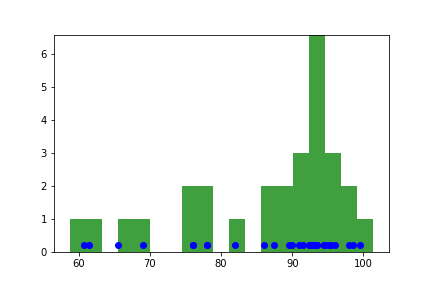
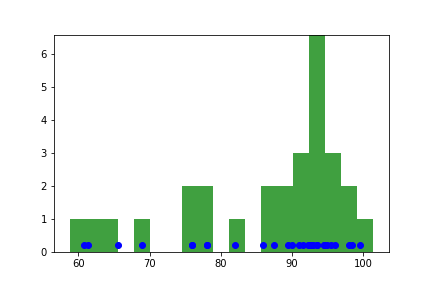
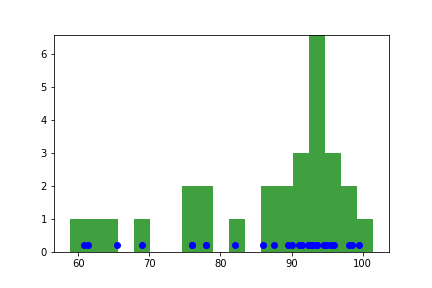
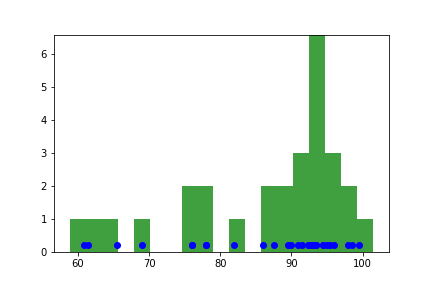
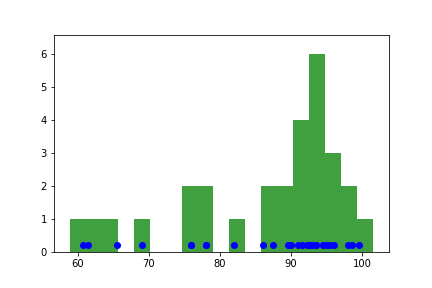
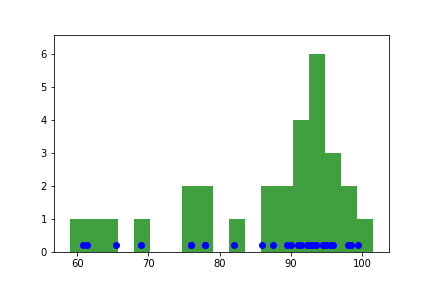
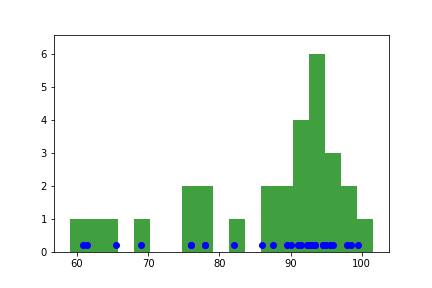
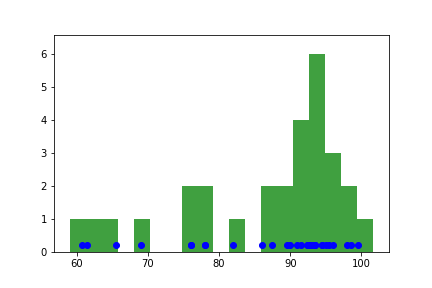
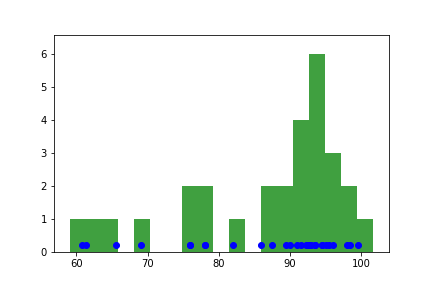
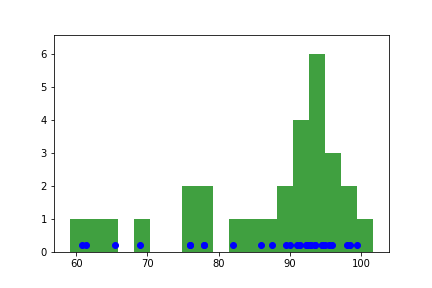
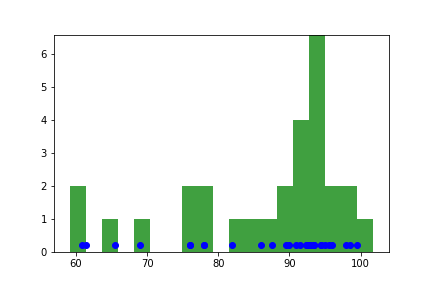
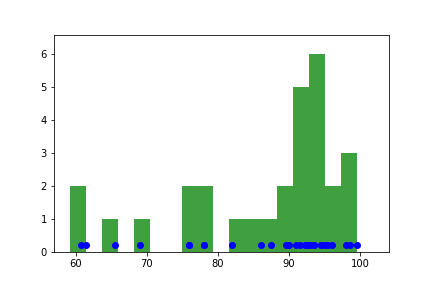
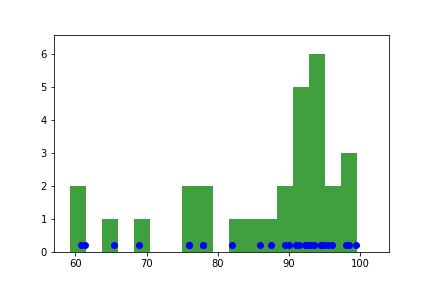
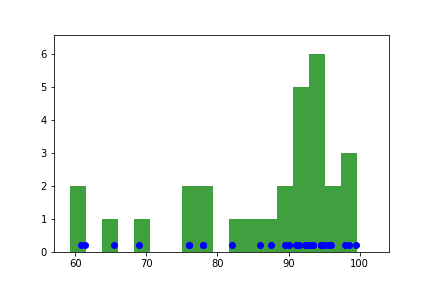
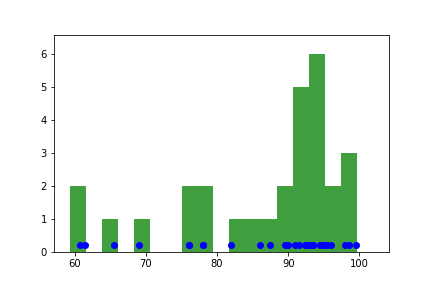
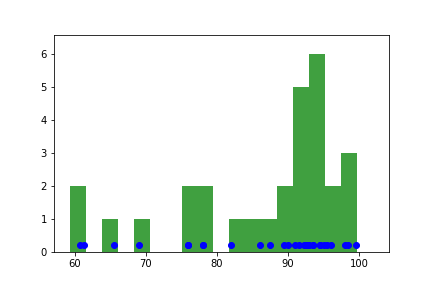
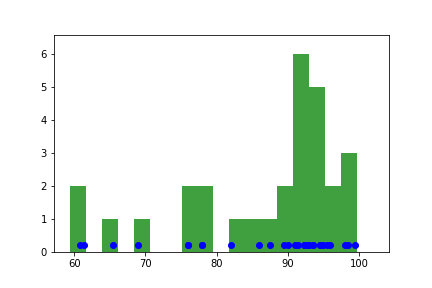
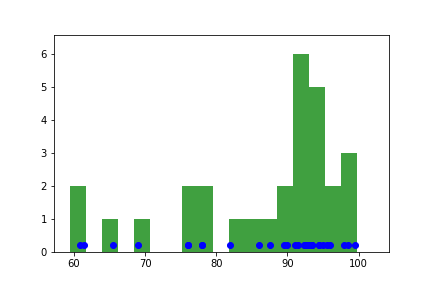
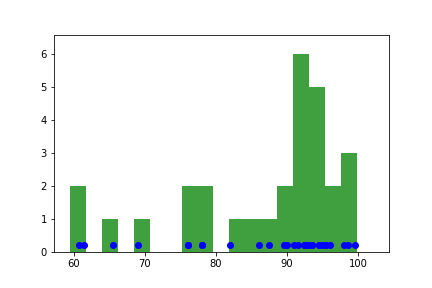
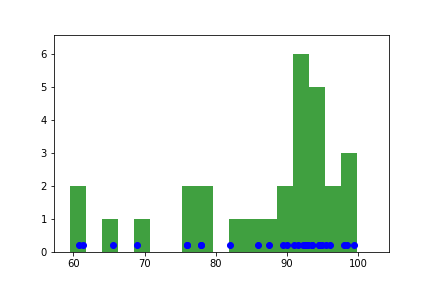
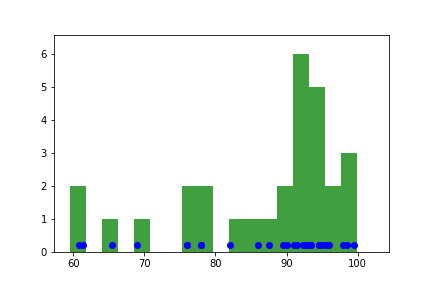
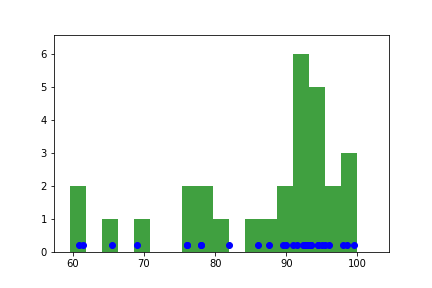
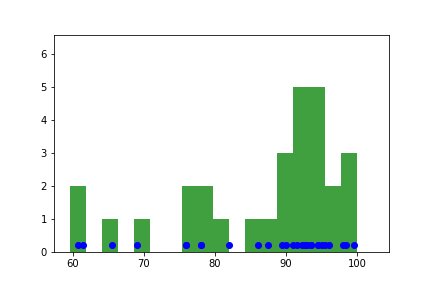
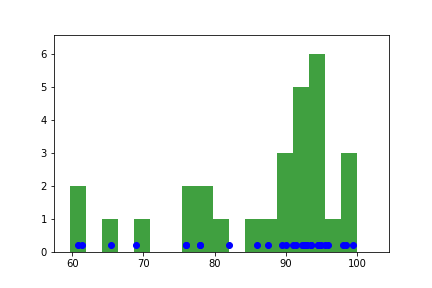
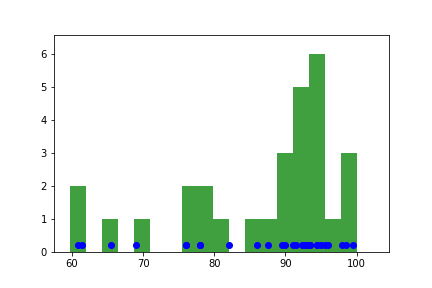
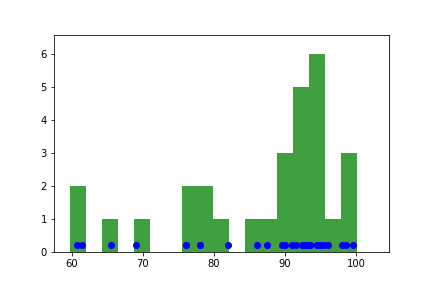
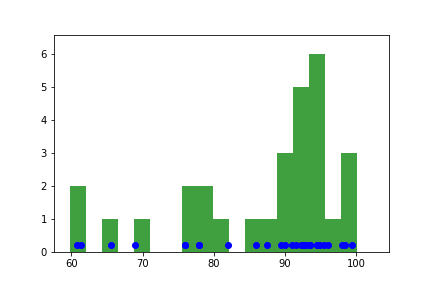
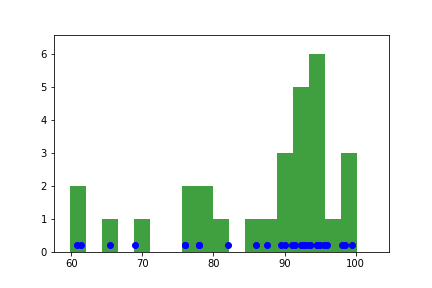

In [12]:
ani = getHistBinOffsetAni(grades)
display_animation(ani, default_mode='once')

<a name="kernels"></a>
## KDE (Kernel Density Estimation) 
is a helpful alternative to histograms. 

The basic idea is that you might choose to represent each point as a little bump with finite width, called a _kernel_. 
Start with a narrow bar of half-transparent gray: 

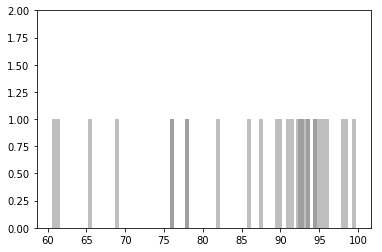

In [13]:
bar(grades,np.ones_like(grades),width=0.5,facecolor='grey',alpha=0.5)
junk=ylim(0, 2.0)

not so interesting ... but what do we do when the rectangles get wide enough that they start to overlap?

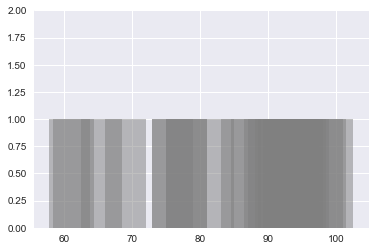

In [54]:
bar(grades,np.ones_like(grades),width=6,facecolor='grey',alpha=0.5)
junk=ylim(0, 2.0)

KDE, rectangular kernel
-----------------------

Instead of shading, let's build up the height of a line plot, with a rectangular kernel:

In [14]:
def getKdeRectAni(data,totalframes=100,showpts=True):
    #ion()
    totalframes = 70
    fig = figure()
    
    # Let's say 10000 points for the whole thing
    width = data.max() - data.min()
    left, right = data.min(), data.min() + (width)
    left, right = left - (totalframes/100)*width, right + (totalframes/100)*width
    
    ax = axes(xlim=(left,right),ylim=(-0.1,2))
    line, = ax.plot([], [], lw=2)
    numpts = 10000
    x = np.linspace(left,right,numpts)
    
    dx = (right-left)/(numpts-1)
    
    def init():
        line.set_data([], [])
        return line

    if showpts:
        junk = plt.plot(data,0.01*ones_like(data),'bo')
    
    def animate(i):
        y = zeros(10000)
        kernelwidth = .02*width*(i+1)
        kernelpts = int(kernelwidth/dx)
        kernel = ones(kernelpts)
        for d in data:
            center = d - left
            centerpts = int(center/dx)
            bottom = centerpts - int(kernelpts/2)
            top = centerpts+int(kernelpts/2)
            if top - bottom < kernelpts: top = top + 1
            if top - bottom > kernelpts: top = top - 1
# Here's the summation of the kernels
            y[bottom:top] += kernel
# Normalize by kernelwidth 
        y /= kernelwidth 
        line.set_data(x,y)
        #ax.set_ylim(0,1.1*y.max())
        ax.set_ylim(0,1.1*3)
        ax.set_xlim(x[where(y>0)[0][0]],x[where(y>0)[0][-1]])
        ax.set_title('Wider and wider rectangular kernels')
    
        #sleep(0.1)
        return line,
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=totalframes, repeat=False)
    return ani


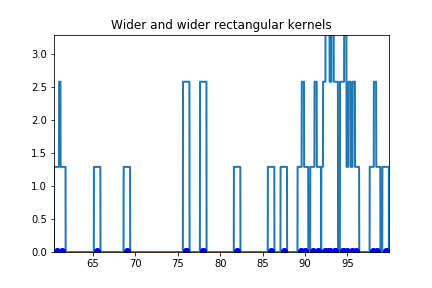
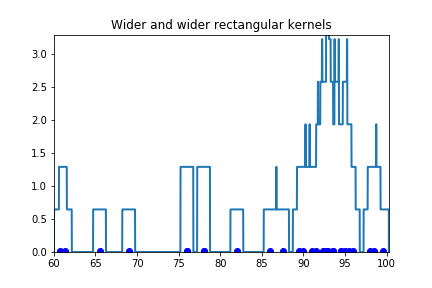
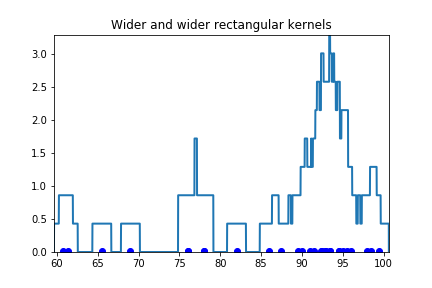
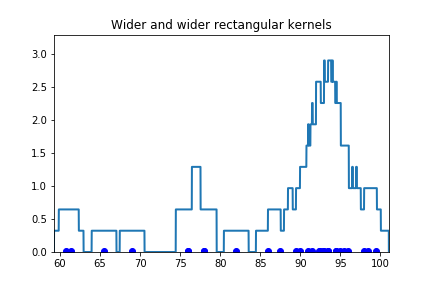
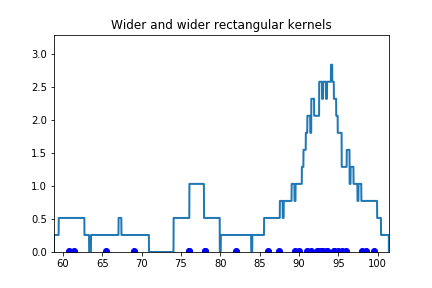
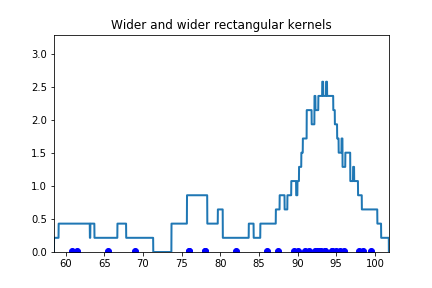
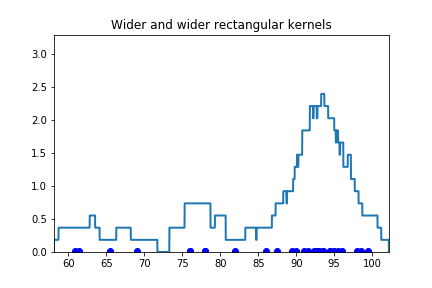
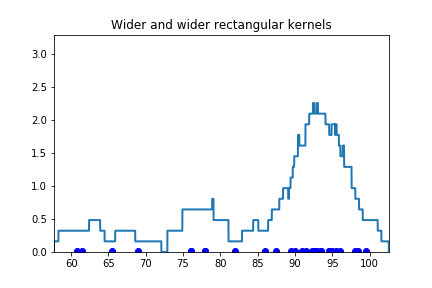
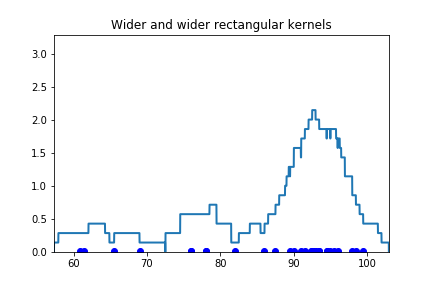
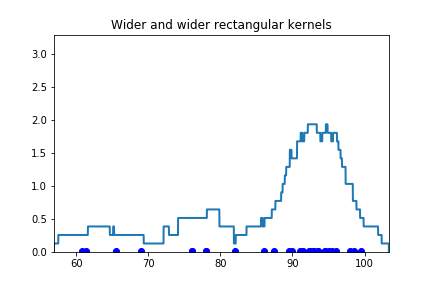
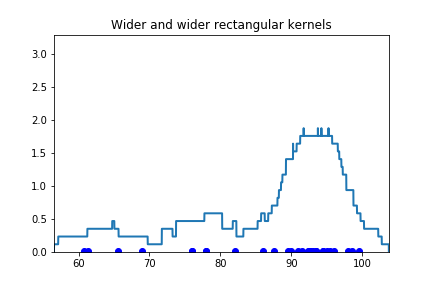
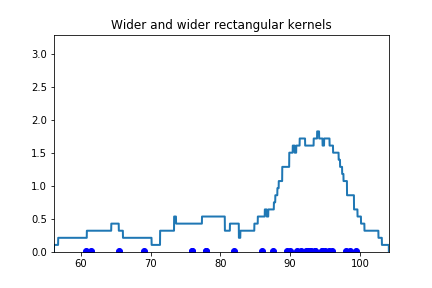
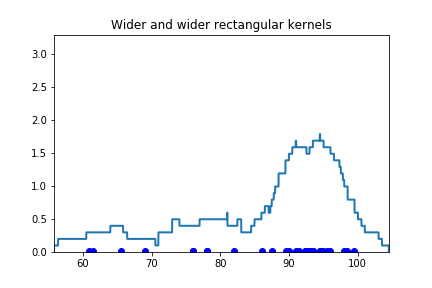
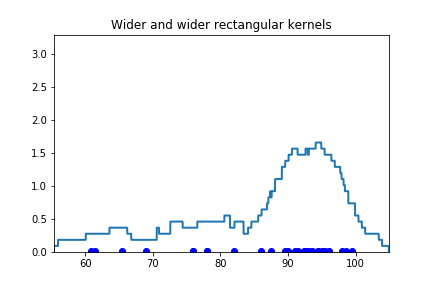
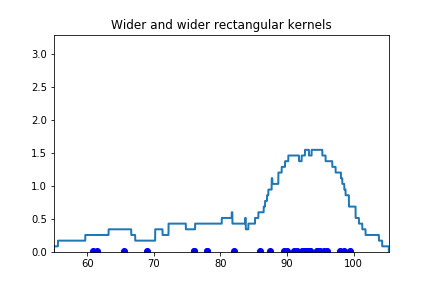
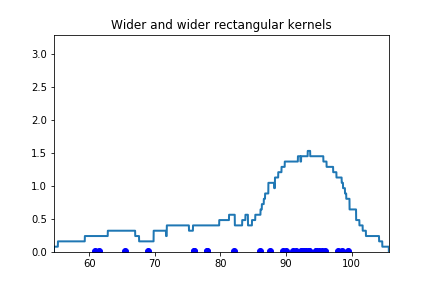
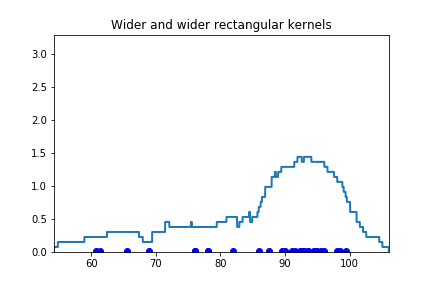
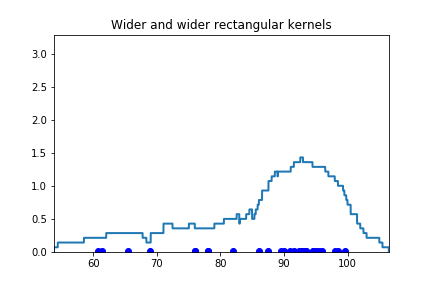
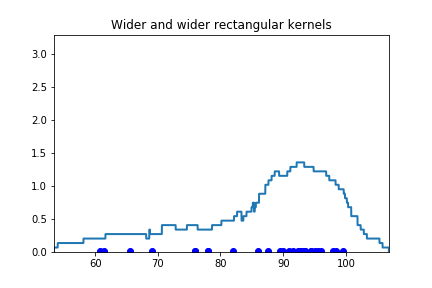
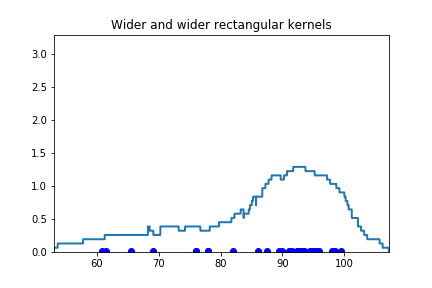
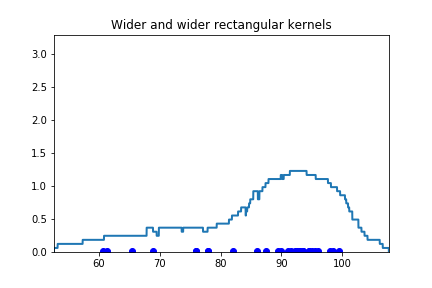
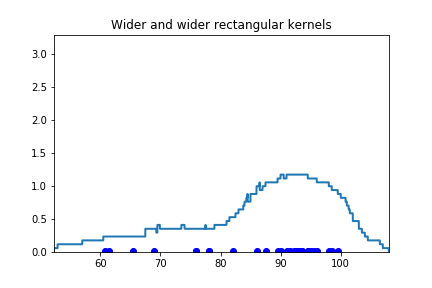
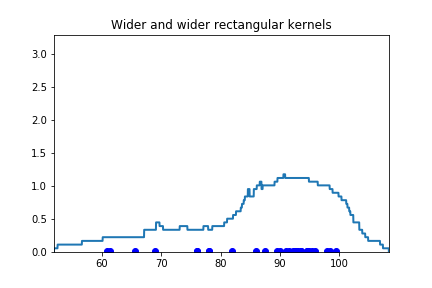
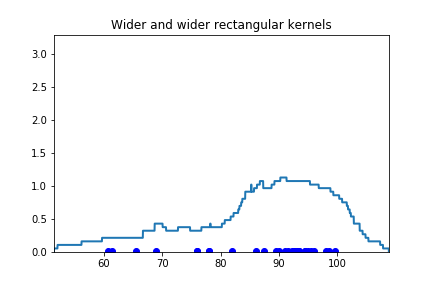
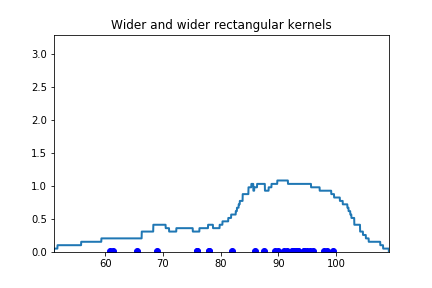
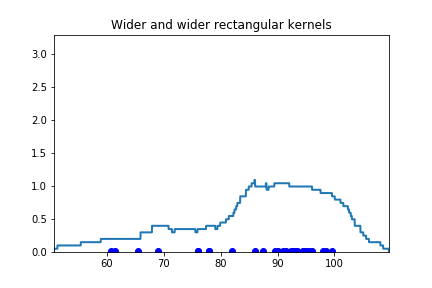
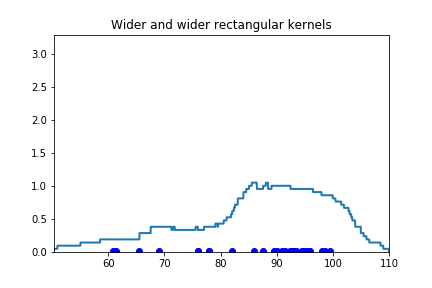
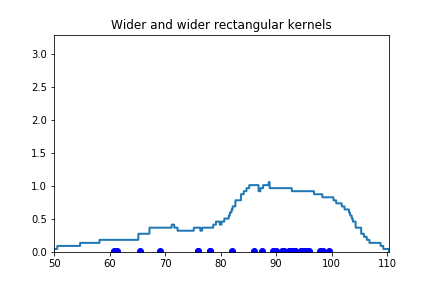
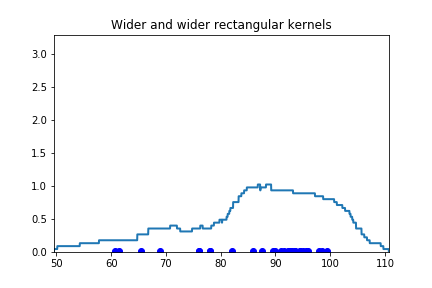
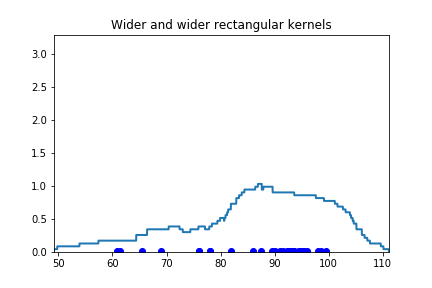
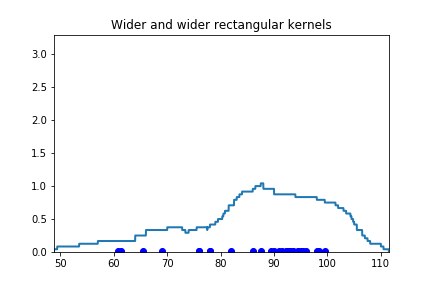
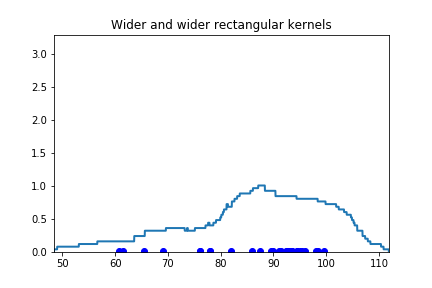
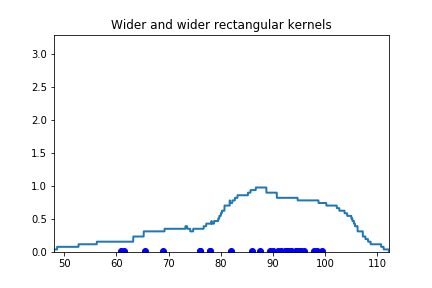
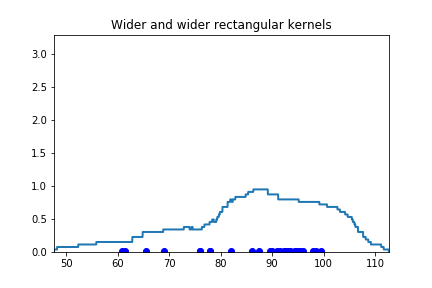
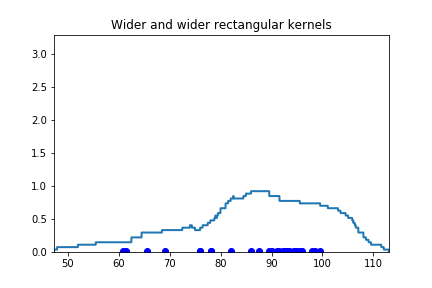
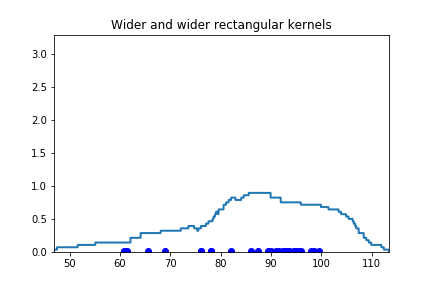
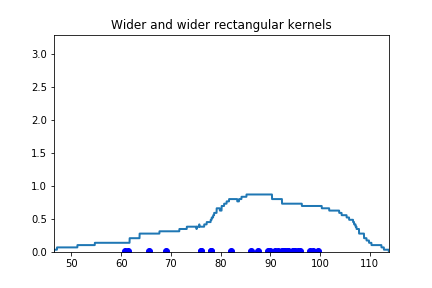
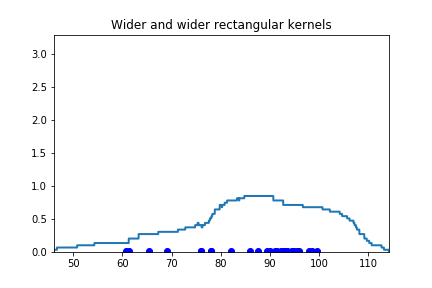
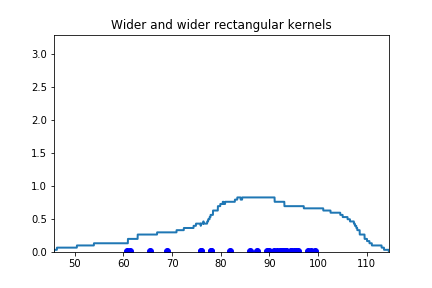
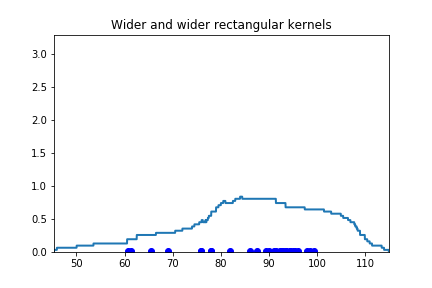
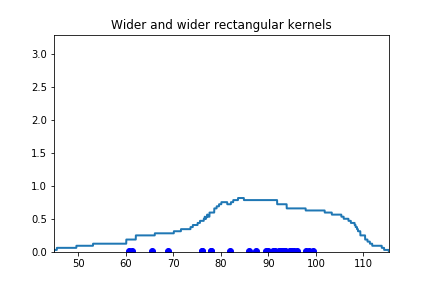
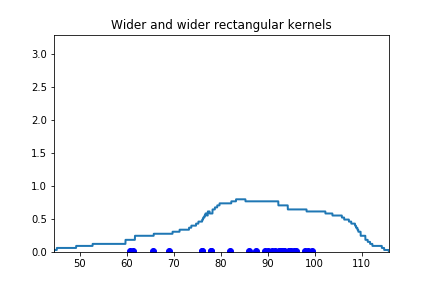
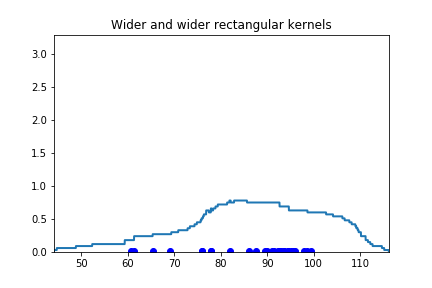
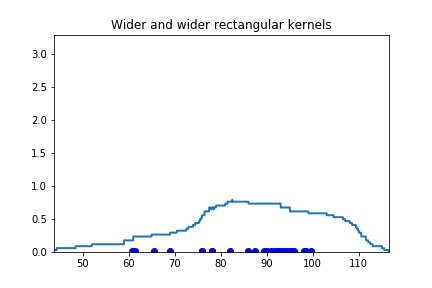
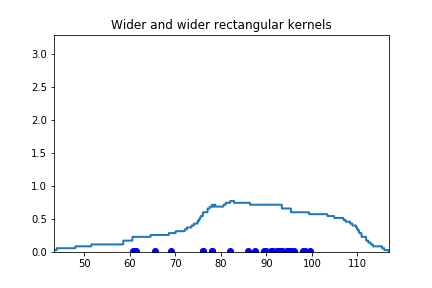
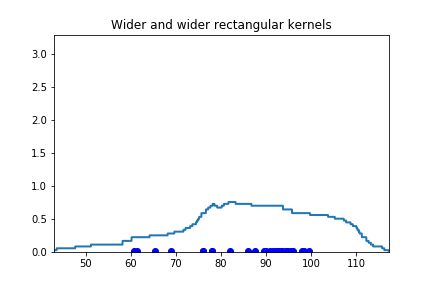
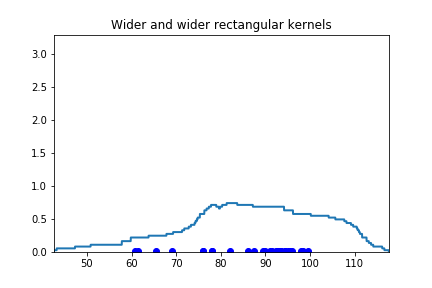
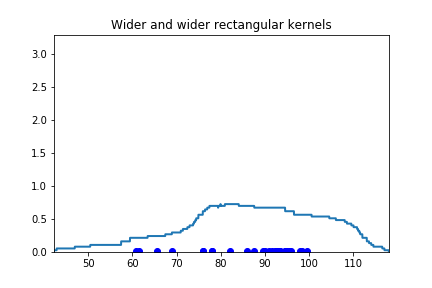
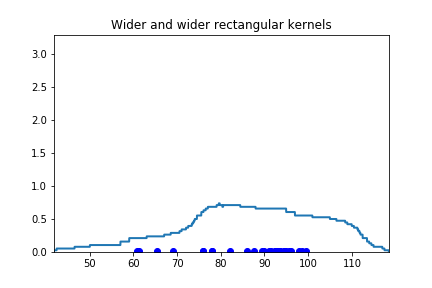
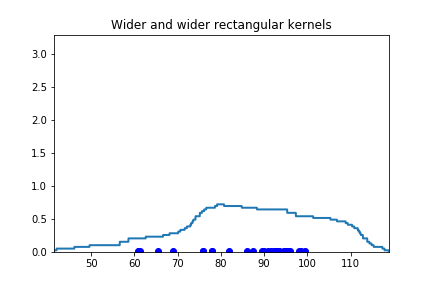
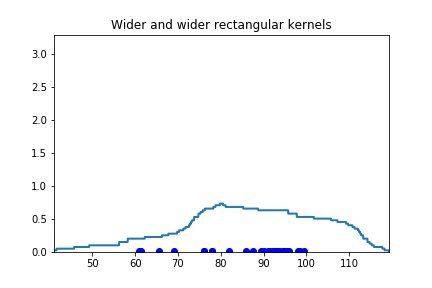
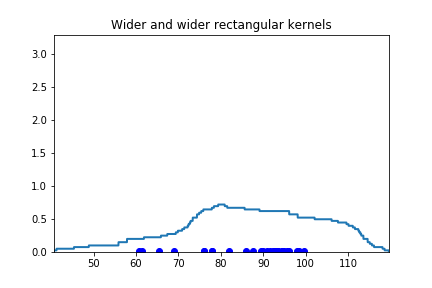
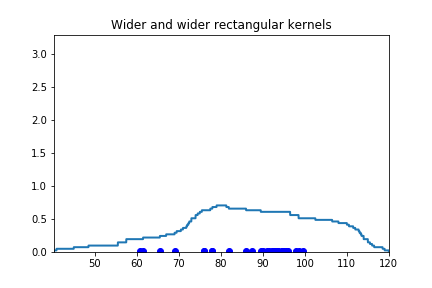
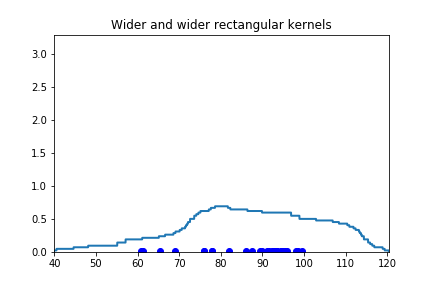
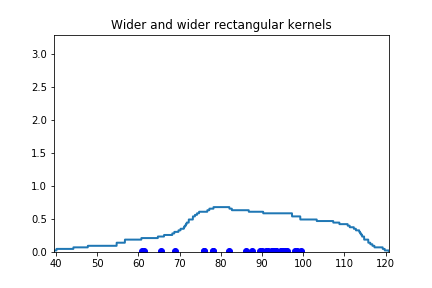
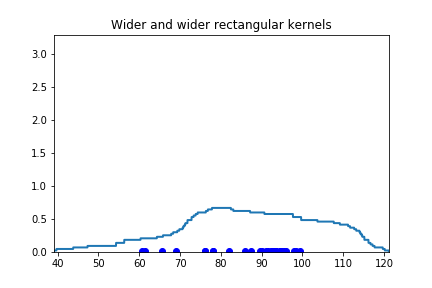
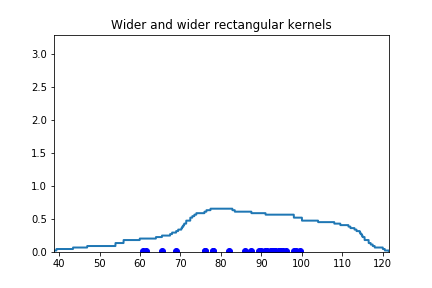
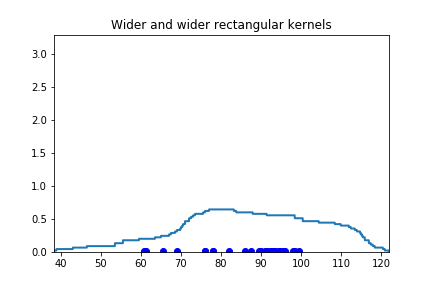
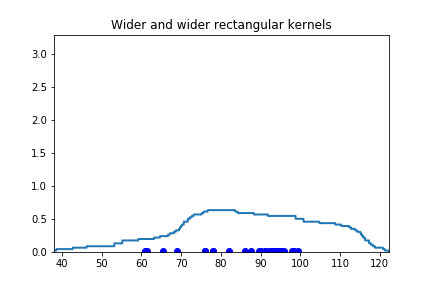
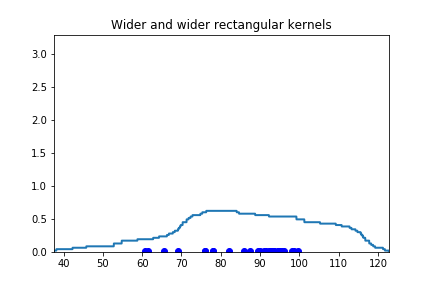
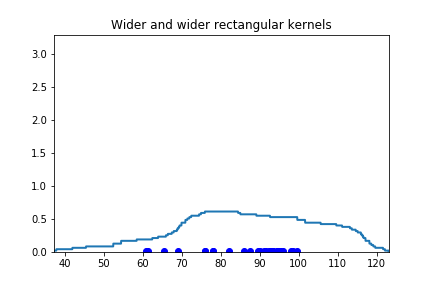
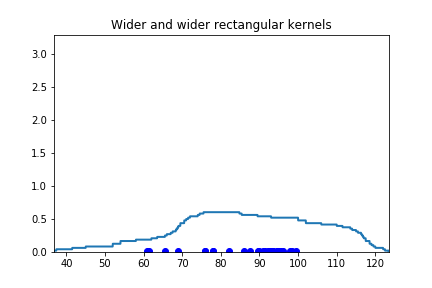
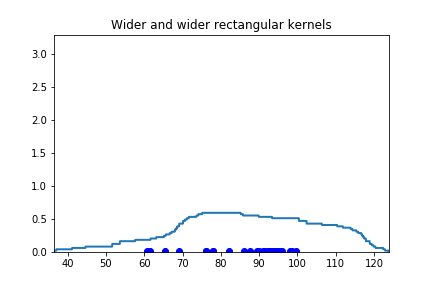
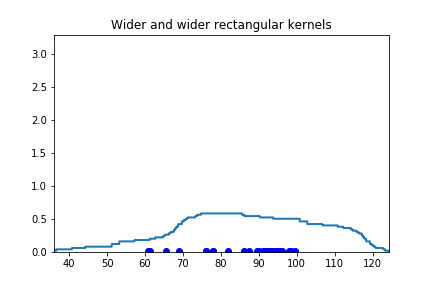
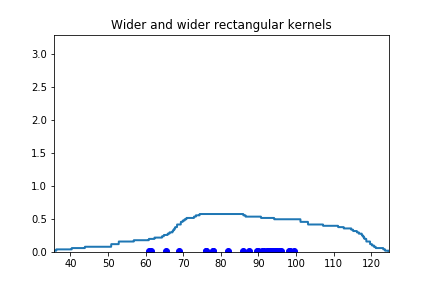
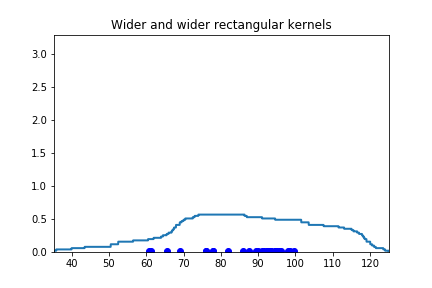
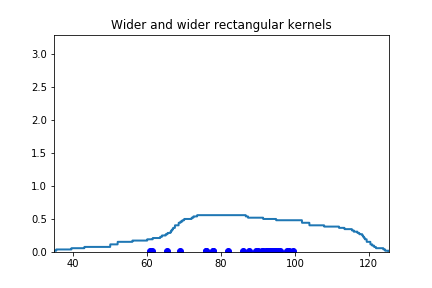
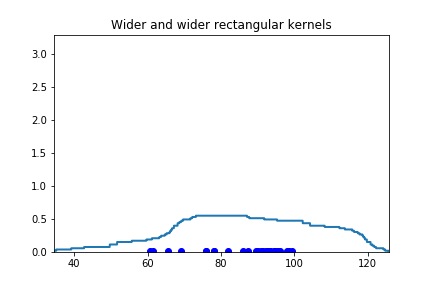
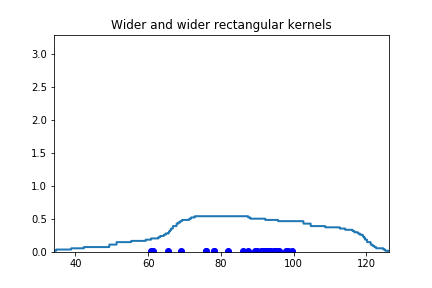
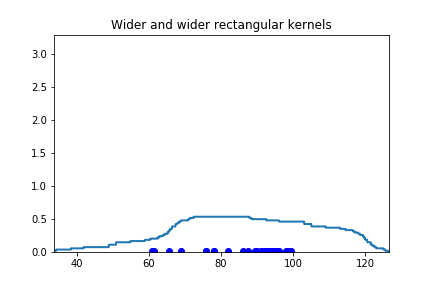

In [15]:
ani = getKdeRectAni(grades)
display_animation(ani, default_mode='once')

By tuning the width of the rectangles (_bandwidth_), we can tune how finely or coarsely we're looking at the data.

In my view, there's a sweet spot right around 1/9 of the way across the slider where there are three distinct peaks. It looks very much like a trimodal distribution to me. So far, this isn't totally automatic; we have to pick the width of our kernel, but it's obvious that KDE can give us a much better view of the underlying data than histograms.

KDE, Gaussian kernel
--------------------


As mentioned above, we can use a different kernel. A package called **scikit-learn** has several kernels we can use.

In [87]:
from sklearn.neighbors import KernelDensity
def plot_kernels():
    """Visualize the KDE kernels available in Scikit-learn"""
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw={'facecolor':'#EEEEEE',
                                       'axisbelow':True})
    ax.grid(color='white', linestyle='-', linewidth=2)
    for spine in ax.spines.values():
        spine.set_color('#BBBBBB')

    X_src = np.zeros((1, 1))
    x_grid = np.linspace(-3, 3, 1000)

    for kernel in ['gaussian', 'tophat', 'epanechnikov',
                   'exponential', 'linear', 'cosine']:
        log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(x_grid[:, None])
        ax.plot(x_grid, np.exp(log_dens), lw=3, alpha=0.5, label=kernel)
    ax.set_ylim(0, 1.05)
    ax.set_xlim(-2.9, 2.9)
    ax.legend()

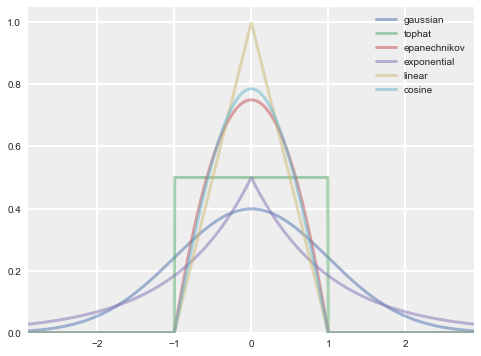

In [88]:
plot_kernels()

One of the most common kernels to use is a [Gaussian](http://en.wikipedia.org/wiki/Gaussian_function). Using `getKdeGaussianAni` function:

In [93]:
from numpy import sqrt, pi, exp

def getKdeGaussianAni(data,totalframes=100, showpts=True):
    fig = figure()
    
    # Let's say 10000 points for the whole thing
    width = data.max() - data.min()
    left, right = data.min(), data.min() + (width)
    left, right = left - (totalframes/100)*width, right + (totalframes/100)*width
    
    ax = axes(xlim=(left,right),ylim=(-0.1,2))
    line, = ax.plot([], [], lw=2)
    if showpts:
        junk = plot(data,ones_like(data)*0.1,'go')

    
    numpts = 10000
    x = linspace(left,right,numpts)
    
    dx = (right-left)/(numpts-1)
    
    def init():
        line.set_data([], [])
        return line,
    
    def gaussian(x,sigma,mu):
        # Why isn't this defined somewhere?! It must be!
        return (1/sqrt(2*pi*sigma**2)) *  exp(-((x-mu)**2)/(2*sigma**2))
    
    def animate(i):
        y = zeros(10000)
        kernelwidth = .02*width*(i+1)
        kernelpts = int(kernelwidth/dx)
        kernel = gaussian(linspace(-3,3,kernelpts),1,0)
        #kernel = ones(kernelpts)
        for d in data:
            center = d - left
            centerpts = int(center/dx)
            bottom = centerpts - int(kernelpts/2)
            top = centerpts+int(kernelpts/2)
            if top - bottom < kernelpts: top = top + 1
            if top - bottom > kernelpts: top = top - 1
            y[bottom:top] += kernel
            
        # y /= kernelwidth # Area under the kernel does not vary linearly with its width 
        ax.set_xlim(x[where(y>0)[0][0]],x[where(y>0)[0][-1]])
        line.set_data(x,y)
# Normalize the y axis for the data range
        ax.set_ylim(min(0,y.min()),1.1*y.max())
        #title('ymin %s ymax %s'%(y.min(),y.max()))

    
        #sleep(0.1)
        return line,
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=totalframes, repeat=False)
    return ani


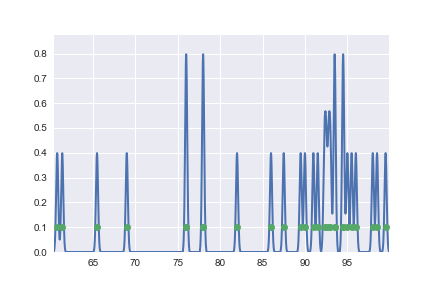
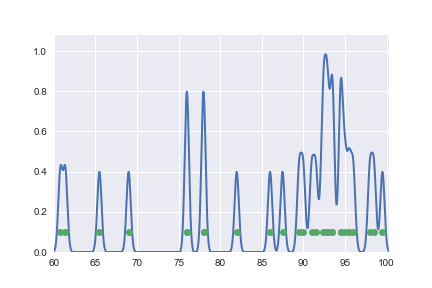
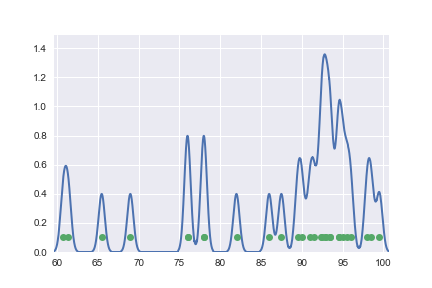
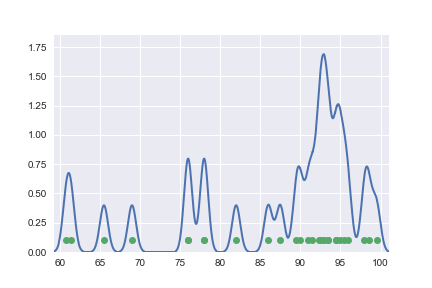
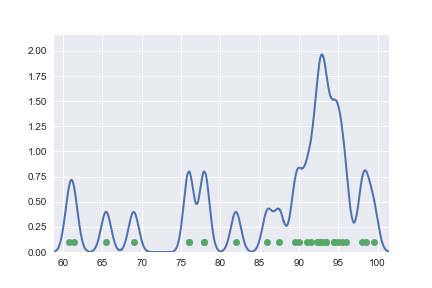
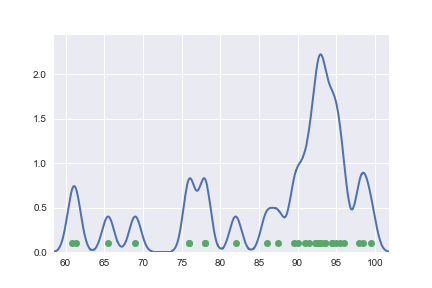
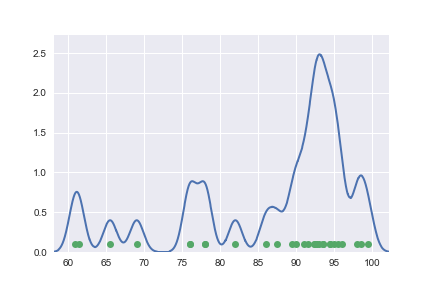
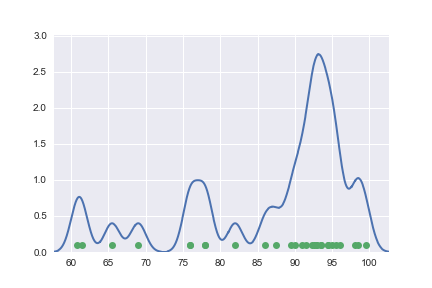
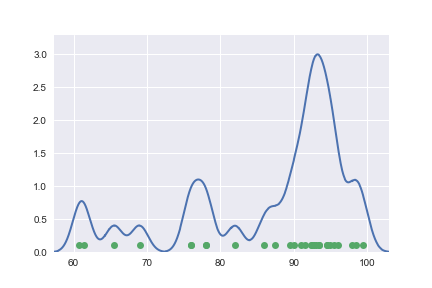
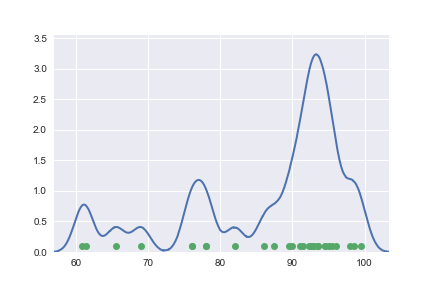
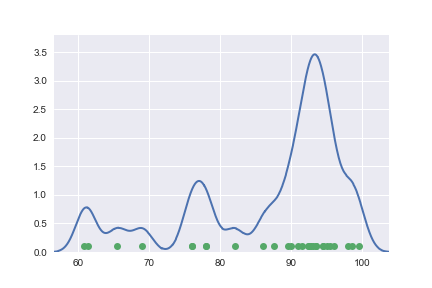
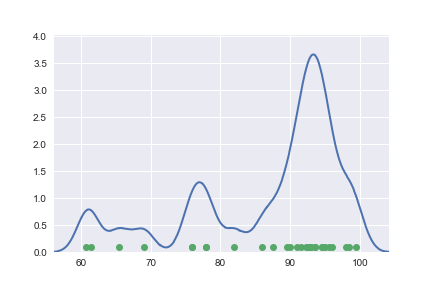
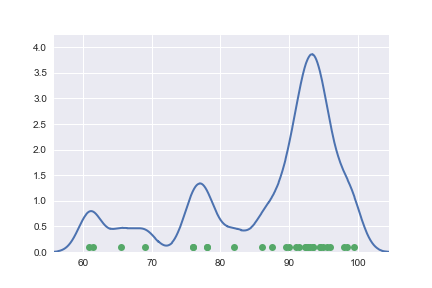
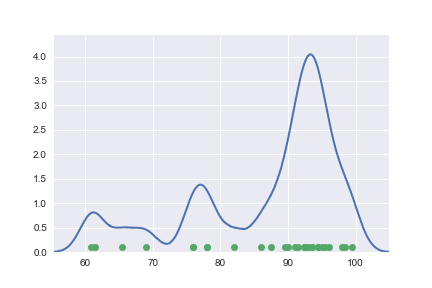
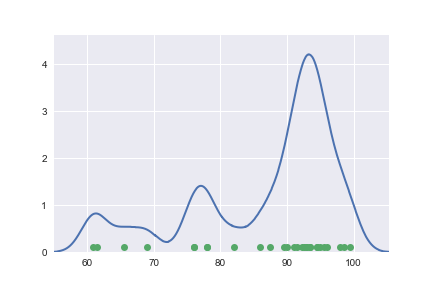
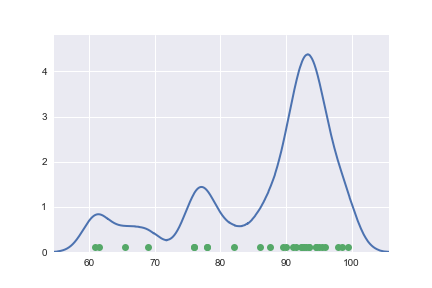
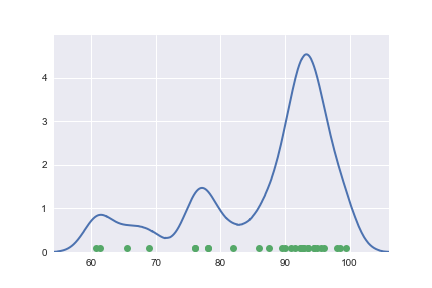
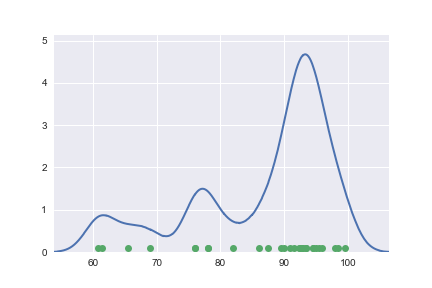
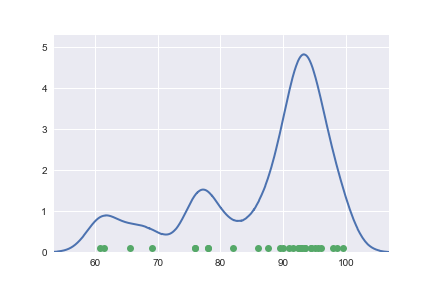
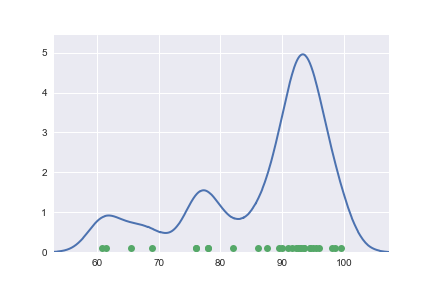
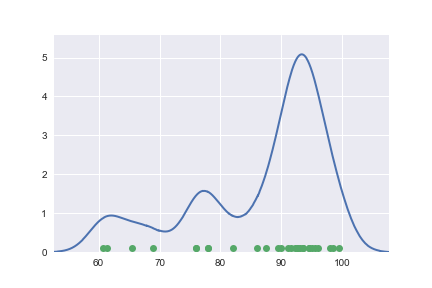
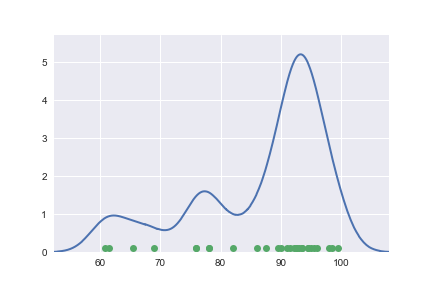
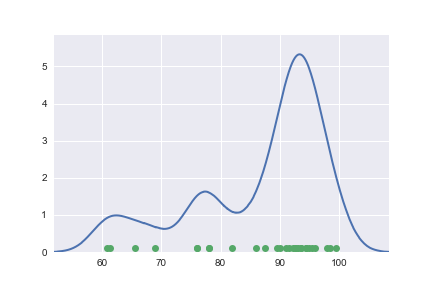
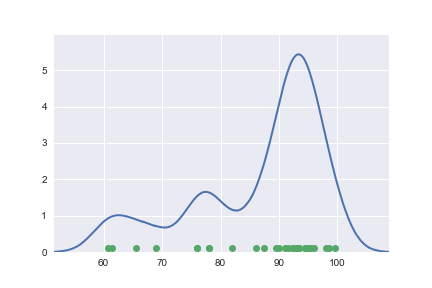
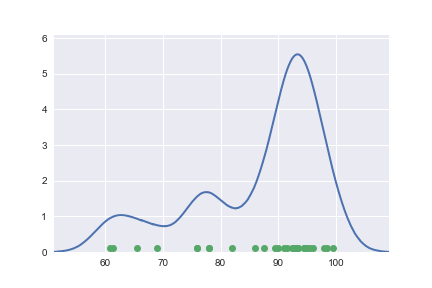
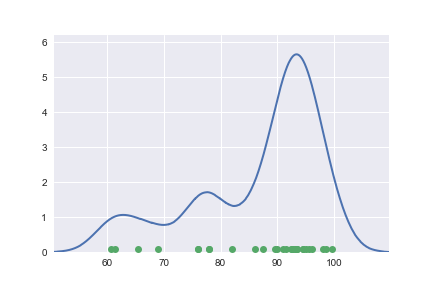
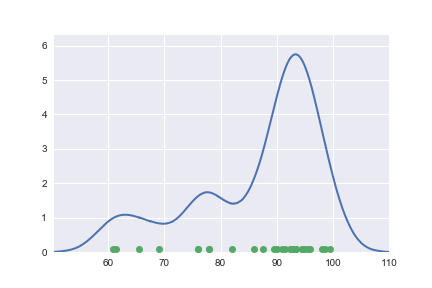
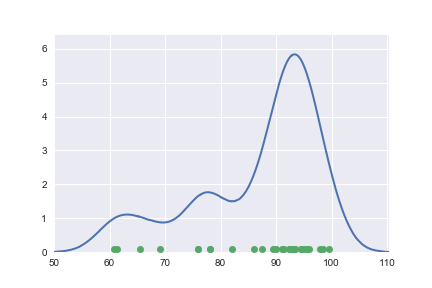
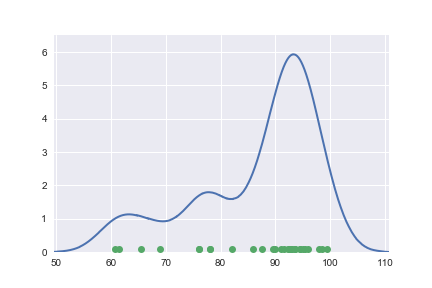
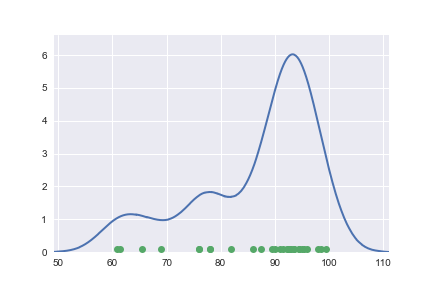
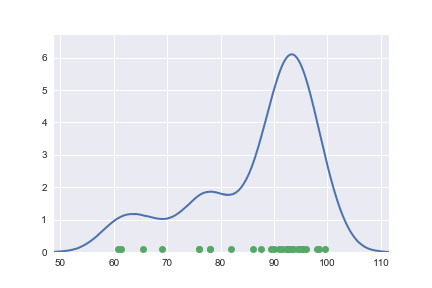
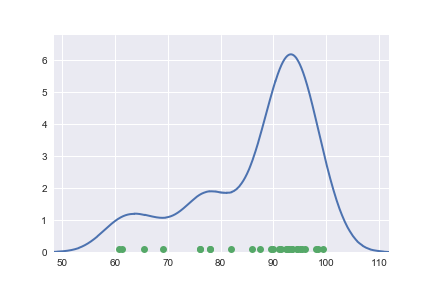
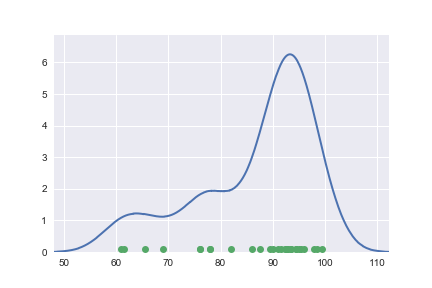
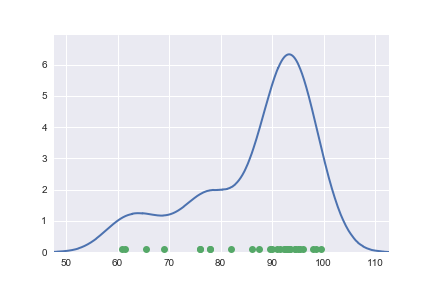
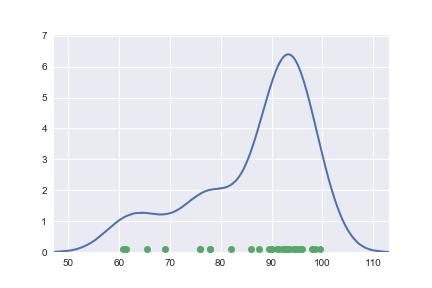
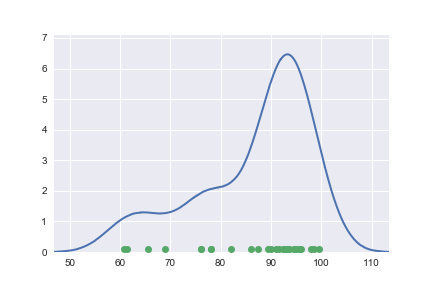
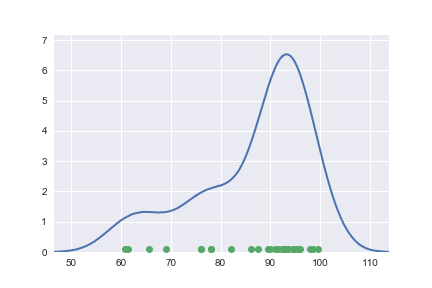
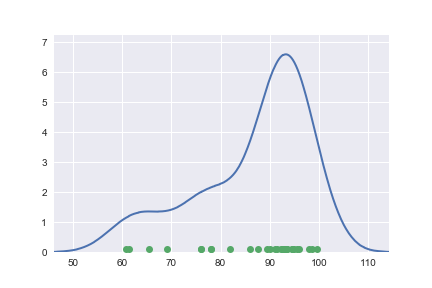
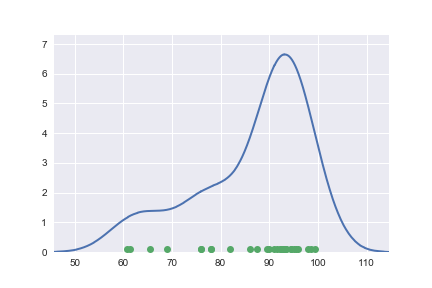
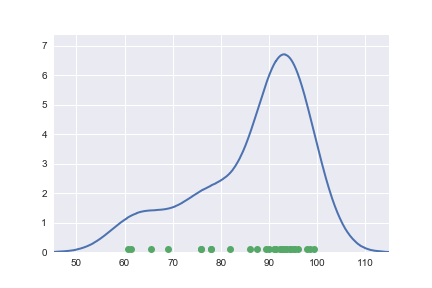
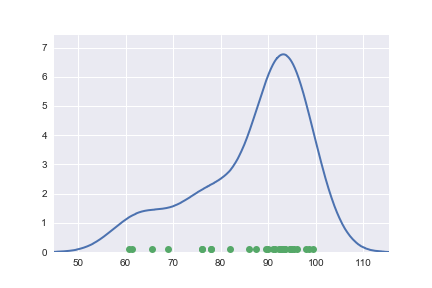
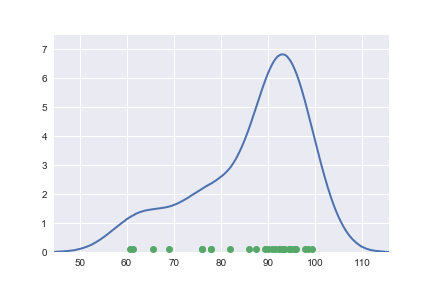
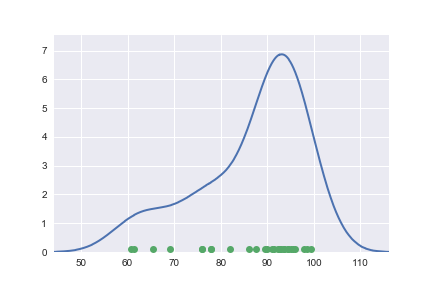
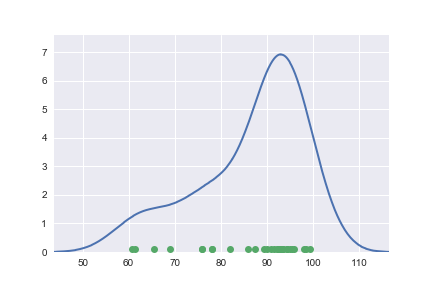
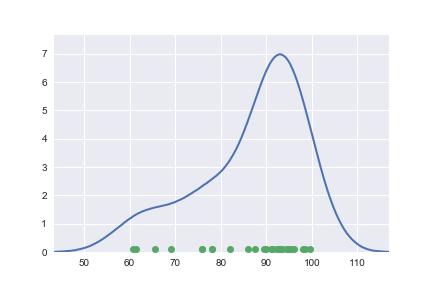
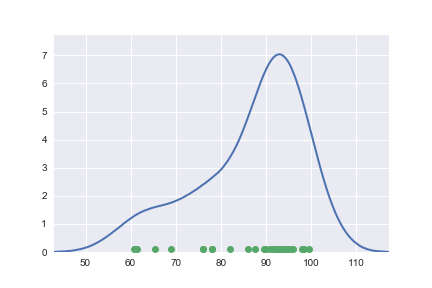
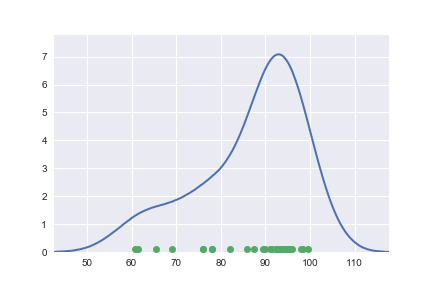
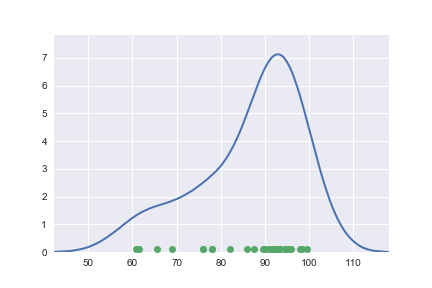
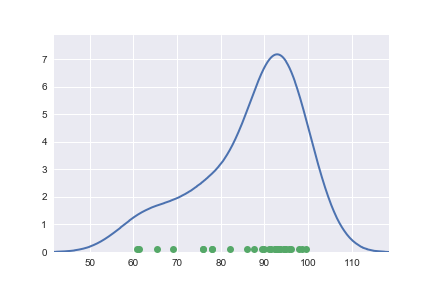
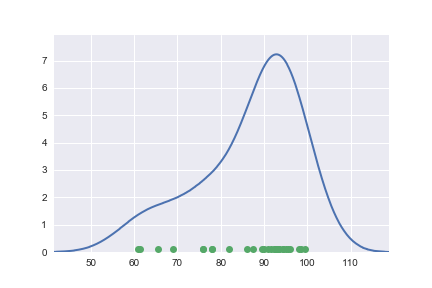
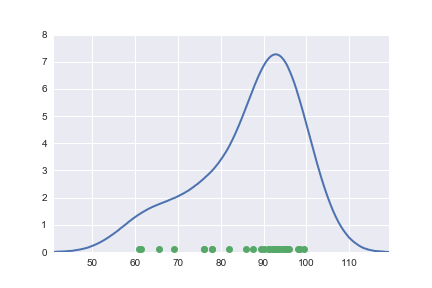
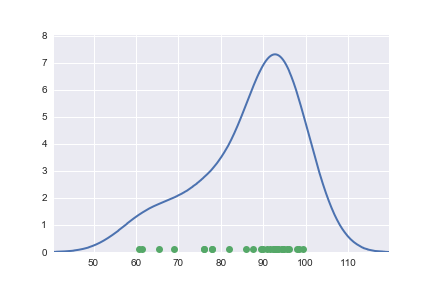
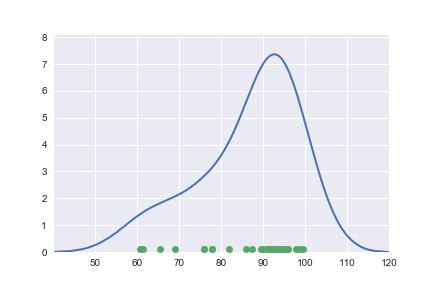
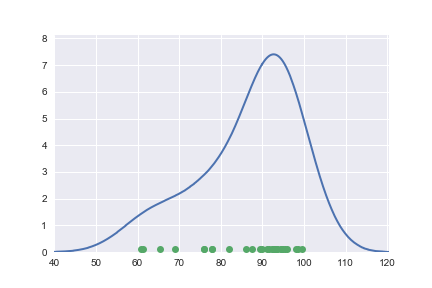
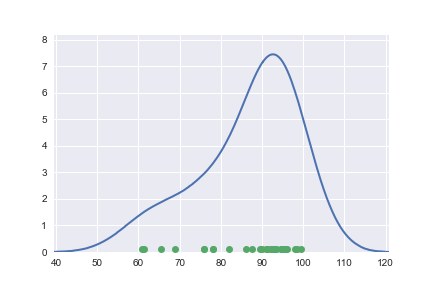
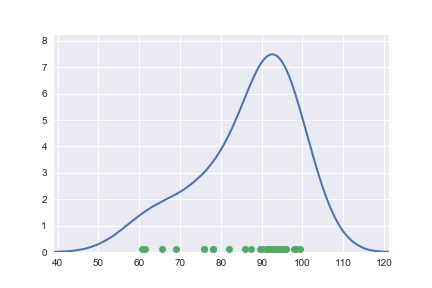
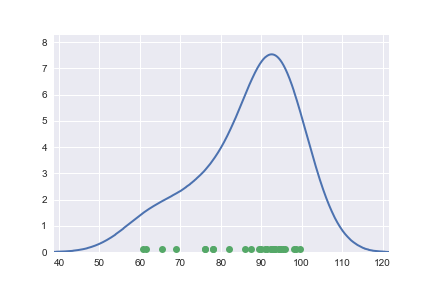
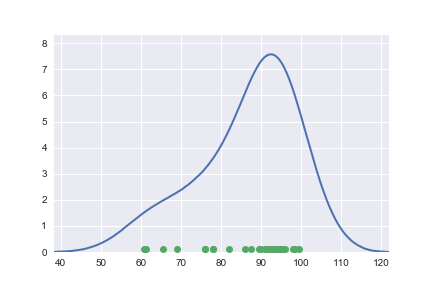
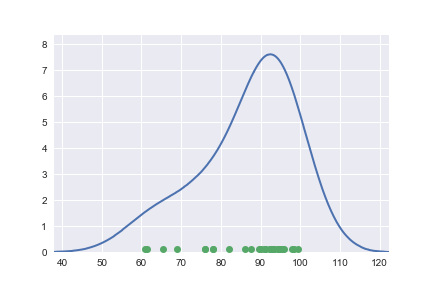
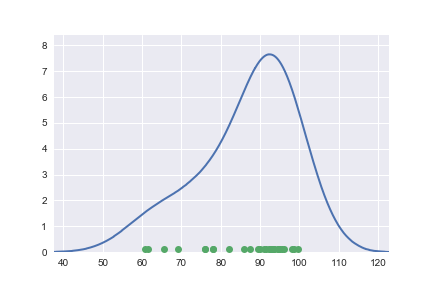
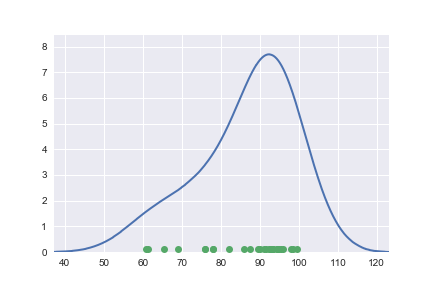
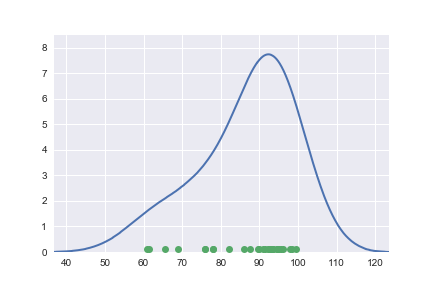
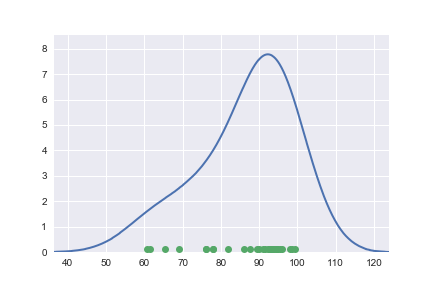
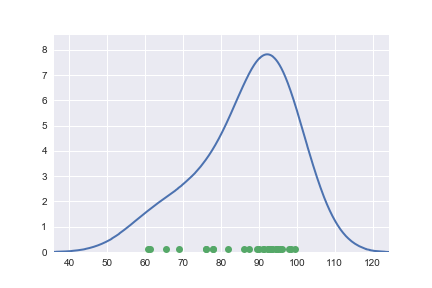
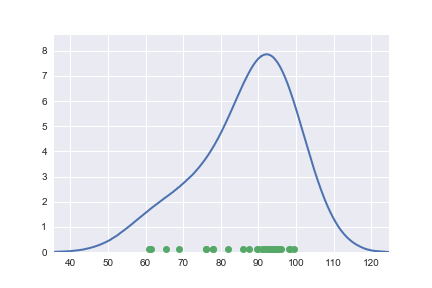
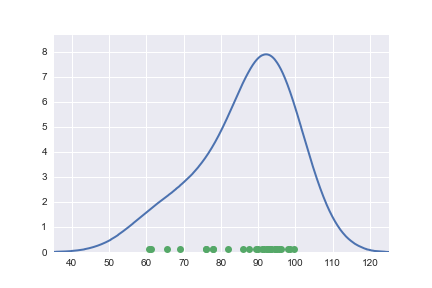
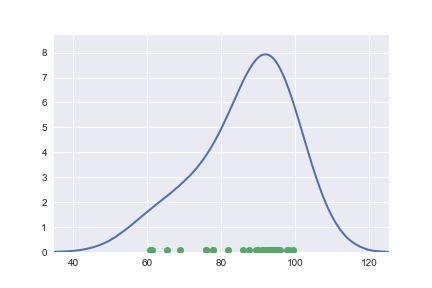
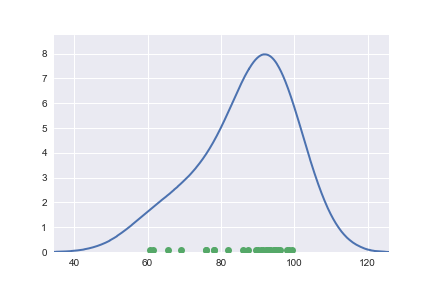
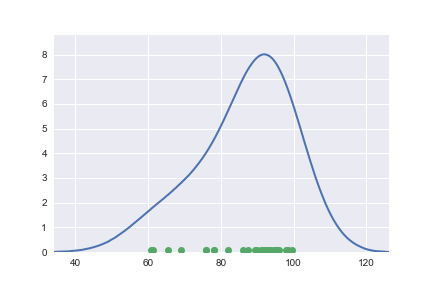
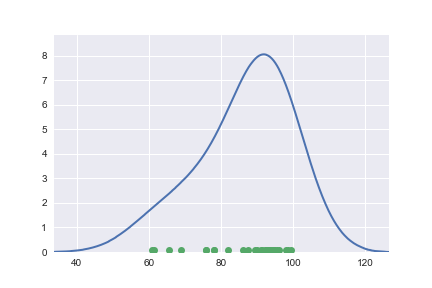
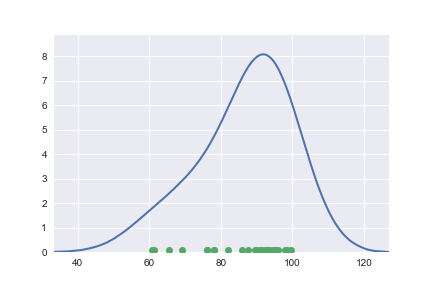
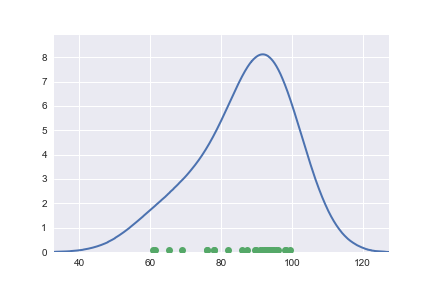
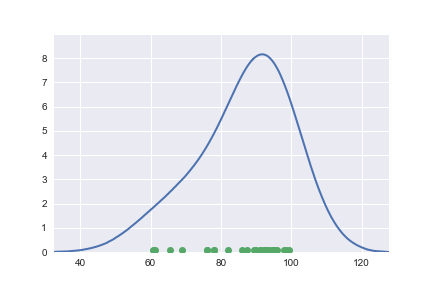
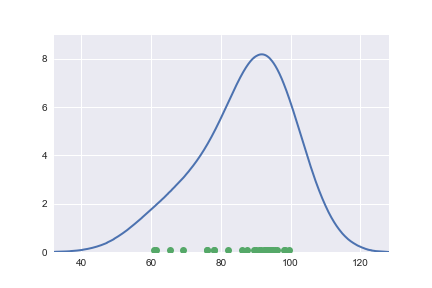
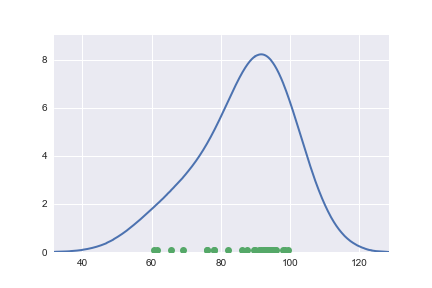
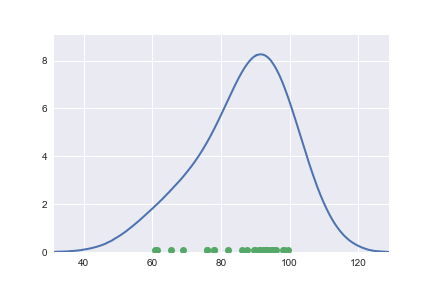
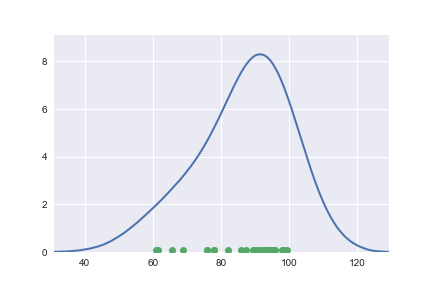
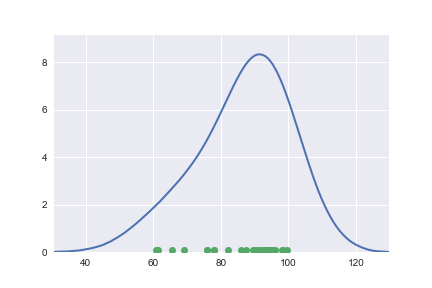
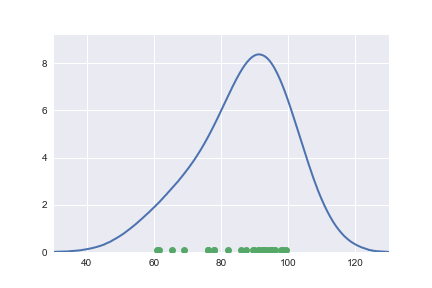
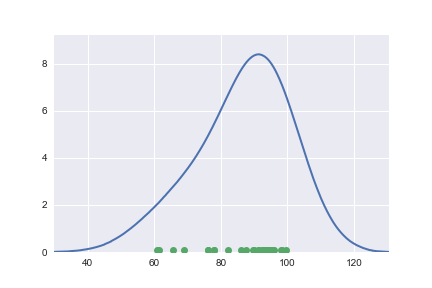
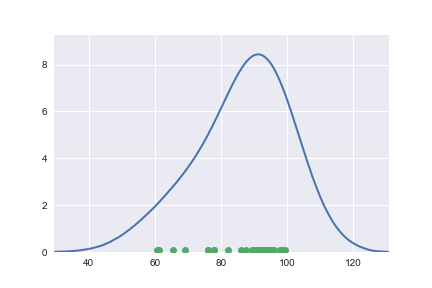
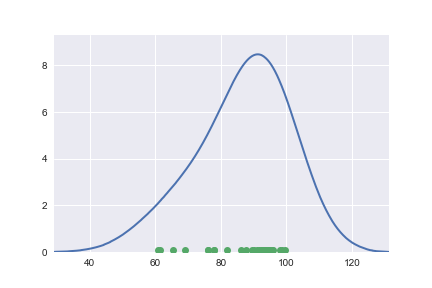
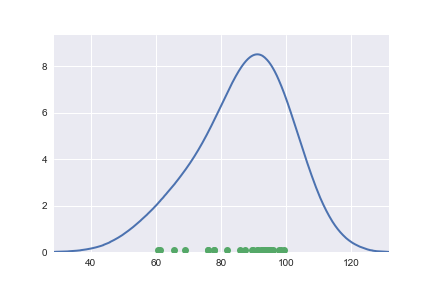
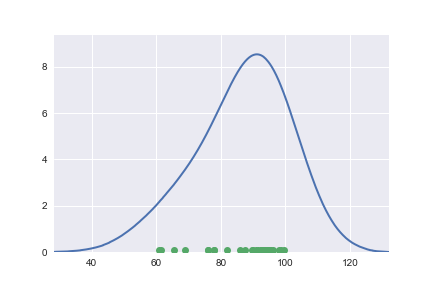
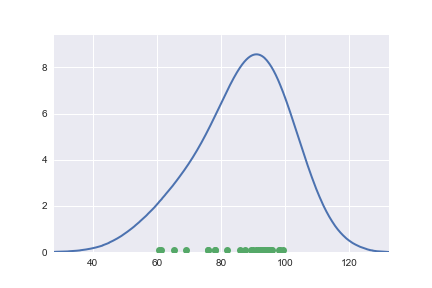
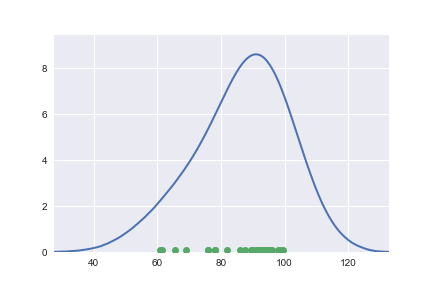
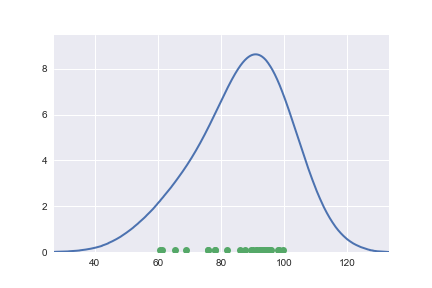
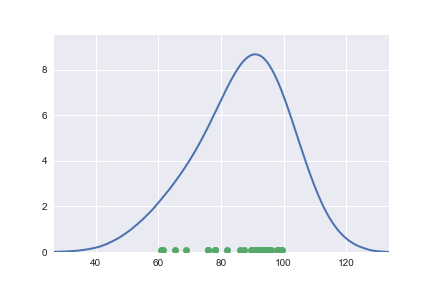
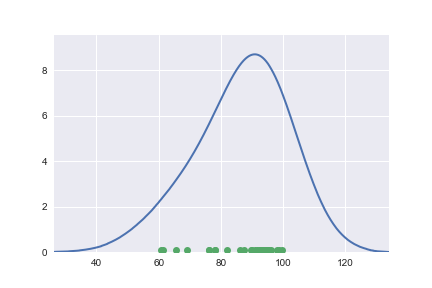
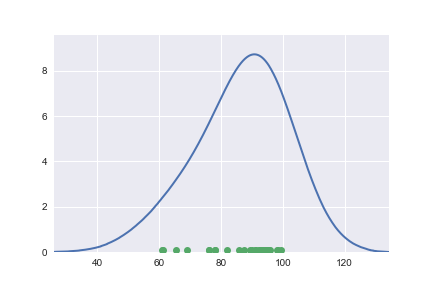
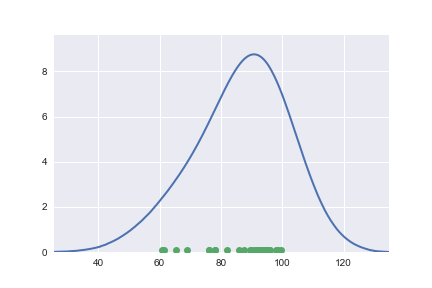
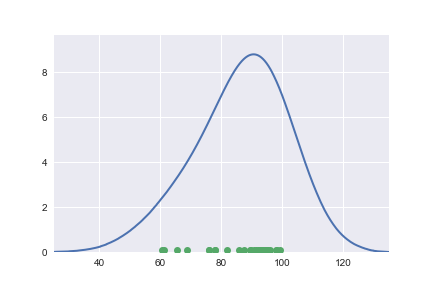
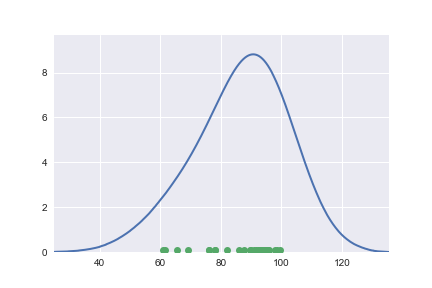
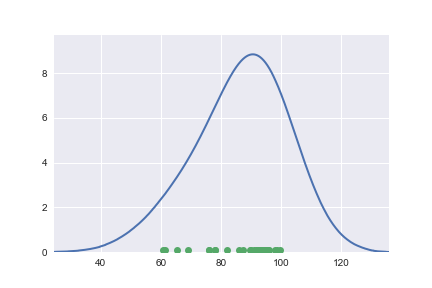
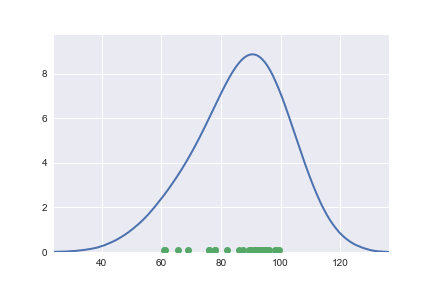
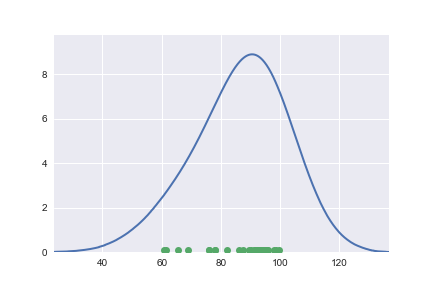
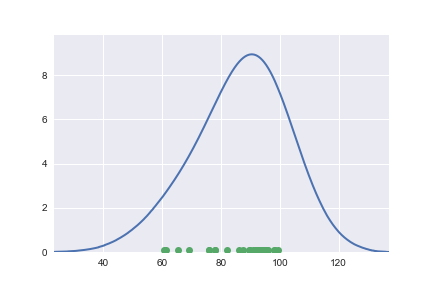
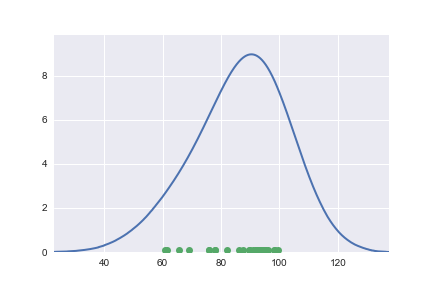
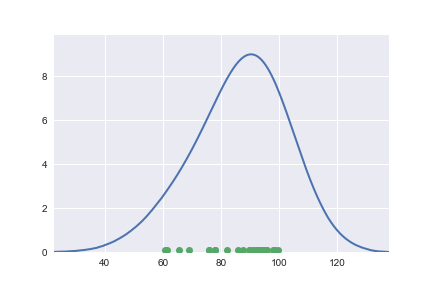
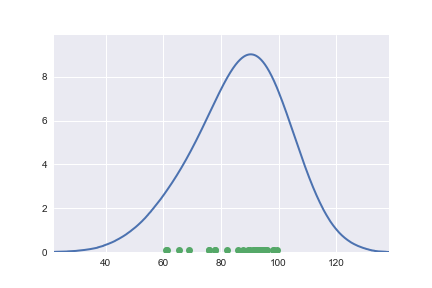

In [94]:
ani = getKdeGaussianAni(grades)
display_animation(ani, default_mode='once')

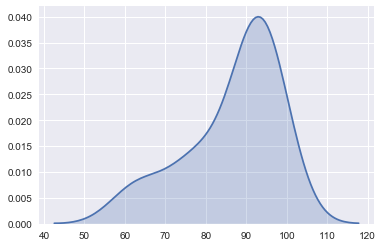

In [100]:
# Default of the KDEplot method in Seaborn
ax = sns.kdeplot(grades, shade=True, color="b")

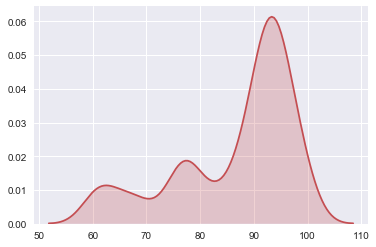

In [101]:
# Try a different kernel width
ax = sns.kdeplot(grades, bw=3, shade=True, color="r")

### Bandwidth Cross-Validation in Scikit-Learn
A formal way to define some best approach: from a machine learning library 

In [111]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [112]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.1, 5, 30)},
                    cv=20) # 20-fold cross-validation
grid.fit(grades[:, None])
print (grid.best_params_)

{'bandwidth': 3.1413793103448278}


In [113]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [119]:
# The grid we'll use for plotting
x_grid = np.linspace(50, 110, 1000)
def fig_bw():
    fig, ax = plt.subplots()
    for bandwidth in [0.5, 1, 3, 10]:
        ax.plot(x_grid, kde_sklearn(grades, x_grid, bandwidth=bandwidth),
                label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
    ax.hist(grades, 20, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
    ax.set_xlim(50, 110)
    ax.set_ylim(0, 0.15)
    ax.legend(loc='upper left')
    ax.set_title('Our bandwidth of 3 is the red one')

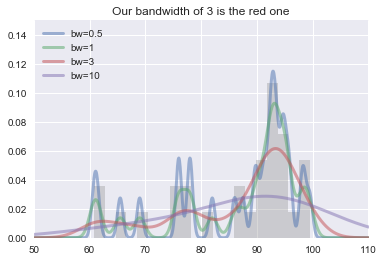

In [120]:
fig_bw()

It is also posible to use the kernel density estimation procedure to visualize a bivariate distribution 

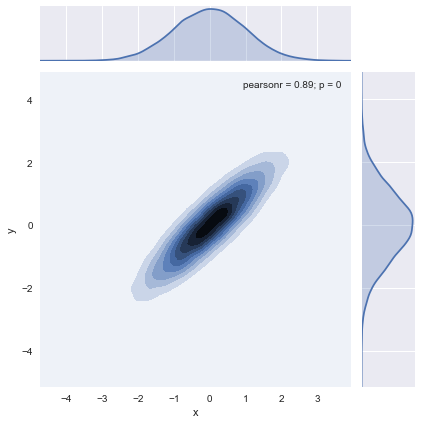

In [121]:
sns.jointplot(x="x", y="y", data=df, kind="kde")

#### Approximate correlation coefficient

This is calculated as usually taught:

\begin{equation}
      r_{xy} = \frac{s_{xy}}{s_xs_y} =\frac{1}{N-1}\frac{\sum_{i=1}^N (x_i-\overline{x})(y_i-\overline{y})}{s_xs_y}
\end{equation}
The correlation coefficient is constrained for fall in the range $\pm 1$. A value of +1 tells us that the
points $(x_i, y_i)$ define a straight line with a positive slope. A value of -1 tells us that the points $(x_i,
y_i)$ define a straight line with a negative slope. A value of 0 shows that there is no dependence of
$y$ on $x$ or vice versa (i.e., no correlation).

It is important to note that $r$ measures the strength of the linear relationship between $x$ and $y$ but a high value of |$r$| does not necessarily imply a cause and effect relationship or that the two variables are linearly related. It is easy to devise non-linear relationships that give a high
correlation coefficient. It is important to look at the data and use common sense.

Note, of course, that $r_{xy}$ is a random variable, and therefore has a probability distribution function, means, and variances.  It therefore is subject to confidence intervals. 

A smart person named Fisher figured out that if we consider the function of $r_{xy}=r$

\begin{equation}
    F(r)=\mathrm{arctanh}(r)
\end{equation}
then $F(r)$ approaches a Normal distribution as $N\to\infty$, with a standard deviation of $\sigma_F=\frac{1}{\sqrt{N-3}}$.

So, if we calculate $r$, then the 95% confidence interval for $F(r)$ is $\pm 1.96/\sqrt{N-3}$, and we can calculate the confidence intervals on $r$ by taking $\tanh\left(F(r)\pm1.96/\sqrt{N-3}\right)$.  (Remember the 95% confidence intervals for a Gaussian with standard deviation of 1 is $\pm1.96$)

Consider the example with the same data (detailed):

In [184]:
N=7000
ntosig=.5
x = np.random.randn(N);x=x-np.mean(x)
y = x + np.random.randn(N)*ntosig;y=y-np.mean(y)
r = np.sum(x*y)/np.std(x,ddof=1)/np.std(y,ddof=1)/(N-1)
print (r)
F = np.arctanh(r)
Fp95 = F+1.96/np.sqrt(N-3)
Fm95 = F-1.96/np.sqrt(N-3)
rp=np.tanh(Fp95)
rm=np.tanh(Fm95)
print ("r= %1.3f (%1.3f,%1.3f)"%(r,rm,rp))

0.8932063114363183
r= 0.893 (0.888,0.898)


This means, based on N=7000, _the true **population** correlation coefficient between X and Y is estimated to be between the two values in parentheses, with 95% confidence_. If we had less data the spread in the 95% confidence interval would be wider:

In [207]:
# N=10 
N=10

ntosig=0.5
x = np.random.randn(N);x=x-np.mean(x)
y = x + np.random.randn(N)*ntosig;y=y-np.mean(y)
r = np.sum(x*y)/np.std(x,ddof=1)/np.std(y,ddof=1)/(N-1)
# print (r)
F = np.arctanh(r)
Fp95 = F+1.96/np.sqrt(N-3)
Fm95 = F-1.96/np.sqrt(N-3)
rp=np.tanh(Fp95)
rm=np.tanh(Fm95)
print ( "r= %1.3f (%1.3f,%1.3f)"%(r,rm,rp) )

r= 0.954 (0.813,0.989)
